In [1]:
# Load the huggingface sst2 dataset
from datasets import load_dataset

dataset = load_dataset("sst2")


f:\Programs\anaconda3\envs\ssm_hw5\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
print(dataset)
print(dataset["train"][0])

DatasetDict({
    train: Dataset({
        features: ['idx', 'sentence', 'label'],
        num_rows: 67349
    })
    validation: Dataset({
        features: ['idx', 'sentence', 'label'],
        num_rows: 872
    })
    test: Dataset({
        features: ['idx', 'sentence', 'label'],
        num_rows: 1821
    })
})
{'idx': 0, 'sentence': 'hide new secretions from the parental units ', 'label': 0}


In [3]:
num_labels = len(set(dataset["train"]["label"]))
print(num_labels)

2


In [4]:
# Delete original test set, split the train set into train and validation, and assign original validation set to test set

dataset["test"] = dataset["validation"]

train_size = int(len(dataset["train"]) * 0.98)
train_set = dataset["train"].select(list(range(train_size)))
validation_set = dataset["train"].select(list(range(train_size, len(dataset["train"]))))
dataset["train"] = train_set
dataset["validation"] = validation_set

print(dataset)

DatasetDict({
    train: Dataset({
        features: ['idx', 'sentence', 'label'],
        num_rows: 66002
    })
    validation: Dataset({
        features: ['idx', 'sentence', 'label'],
        num_rows: 1347
    })
    test: Dataset({
        features: ['idx', 'sentence', 'label'],
        num_rows: 872
    })
})


In [5]:
from transformers import AutoTokenizer, RobertaModel, RobertaForSequenceClassification
import torch

tokenizer = AutoTokenizer.from_pretrained("roberta-base")
# model = RobertaModel.from_pretrained("FacebookAI/roberta-base")
model = RobertaForSequenceClassification.from_pretrained("roberta-base", num_labels=num_labels)


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [6]:
# Get the LoRA model
from peft import LoraConfig, get_peft_model, TaskType

lora_config = LoraConfig(
    r=8,
    lora_alpha=32,
    lora_dropout=0.05,
    target_modules=['query', 'key', 'value'],
    task_type=TaskType.SEQ_CLS
)

lora_model = get_peft_model(model, lora_config)

total_params = sum(param.numel() for param in lora_model.parameters())
trainable_params = sum(param.numel() for param in lora_model.parameters() if param.requires_grad)
print(f"Total params: {total_params}")
print(f"Trainable params: {trainable_params}")
print(f"Percentage trainable: {trainable_params / total_params * 100:.2f}%")

Total params: 125681668
Trainable params: 1034498
Percentage trainable: 0.82%


In [7]:
# Tokenize the dataset
def tokenize_function(examples):
    return tokenizer(examples["sentence"], padding="max_length", truncation=True)

tokenized_dataset = dataset.map(tokenize_function, batched=True)

# Print the first example of the training set
print(tokenized_dataset["train"][0])



{'idx': 0, 'sentence': 'hide new secretions from the parental units ', 'label': 0, 'input_ids': [0, 37265, 92, 3556, 2485, 31, 5, 20536, 2833, 1437, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,

In [8]:
from transformers import Trainer, TrainingArguments
from datasets import load_metric
import numpy as np
import logging

# Hyperparameters
step_size = 500
lr = 1e-4
num_epochs = 8

# Eval metric for accuracy
metric = load_metric("accuracy")
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    result = metric.compute(predictions=predictions, references=labels)

    return result


# Custom trainer for logging training accuracy
class TrainerWithTrainingAccuracy(Trainer):
    training_accuracies = []
    # curr_step = 0

    def training_step(self, model, inputs):
        # Perform a regular training step
        loss = super().training_step(model, inputs)
        
        # Compute training accuracy after every training step
        self.log_training_accuracy(inputs)
        return loss

    def log_training_accuracy(self, inputs):
        model.eval()
        with torch.no_grad():
            outputs = self.model(**inputs)
            logits = outputs.logits
            labels = inputs["labels"]
            predictions = np.argmax(logits.cpu().numpy(), axis=-1)
            labels = labels.cpu().numpy()
            accuracy = metric.compute(predictions=predictions, references=labels)
            self.training_accuracies.append(accuracy["accuracy"])
            # self.log({"train_accuracy": accuracy["accuracy"]})
        if len(self.training_accuracies) % step_size == 0:
            self.log({"train_accuracy": sum(self.training_accuracies) / len(self.training_accuracies)})
            self.training_accuracies = []
        model.train()


training_args = TrainingArguments(
    per_device_train_batch_size=4,
    per_device_eval_batch_size=4,
    num_train_epochs=num_epochs,
    logging_dir='./lora_logs',
    logging_steps=step_size,
    do_train=True,
    do_eval=True,
    evaluation_strategy="steps",
    eval_steps=step_size,
    output_dir='./lora_results',
    overwrite_output_dir=True,
    save_steps=step_size,
    save_total_limit=20,
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    learning_rate=lr,
    # warmup_steps=500,
)

trainer = TrainerWithTrainingAccuracy(
    model=lora_model, 
    args=training_args,
    train_dataset=tokenized_dataset["train"], 
    eval_dataset=tokenized_dataset["validation"],
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

trainer.train()




C:\Users\Shaobo Liang\AppData\Local\Temp\ipykernel_15436\438648003.py:12: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  metric = load_metric("accuracy")
f:\Programs\anaconda3\envs\ssm_hw5\lib\site-packages\datasets\load.py:753: FutureWarning: The repository for accuracy contains custom code which must be executed to correctly load the metric. You can inspect the repository content at https://raw.githubusercontent.com/huggingface/datasets/2.17.1/metrics/accuracy/accuracy.py
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this metric from the next major release of `datasets`.
  warnings.warn(
f:\Programs\anaconda3\envs\ssm_hw5\lib\site-packages\accelerate\accelerator.py:446: FutureWarning: Passing the following arguments to `Accelerator` i

{'train_accuracy': 0.8185, 'epoch': 0.03}
{'loss': 0.5857, 'learning_rate': 9.962123507666202e-05, 'epoch': 0.03}


                                                      
  0%|          | 500/132008 [00:47<2:50:01, 12.89it/s]

{'eval_loss': 0.4345104992389679, 'eval_accuracy': 0.8901262063845583, 'eval_runtime': 7.2992, 'eval_samples_per_second': 184.542, 'eval_steps_per_second': 46.17, 'epoch': 0.03}


  1%|          | 1000/132008 [01:26<2:49:43, 12.86it/s]

{'train_accuracy': 0.8985, 'epoch': 0.06}
{'loss': 0.484, 'learning_rate': 9.924247015332404e-05, 'epoch': 0.06}


                                                       
  1%|          | 1000/132008 [01:33<2:49:43, 12.86it/s]

{'eval_loss': 0.4166661202907562, 'eval_accuracy': 0.8901262063845583, 'eval_runtime': 7.3196, 'eval_samples_per_second': 184.027, 'eval_steps_per_second': 46.041, 'epoch': 0.06}


  1%|          | 1500/132008 [02:13<2:48:56, 12.88it/s] 

{'train_accuracy': 0.9045, 'epoch': 0.09}
{'loss': 0.439, 'learning_rate': 9.886370522998607e-05, 'epoch': 0.09}


                                                       
  1%|          | 1500/132008 [02:20<2:48:56, 12.88it/s]

{'eval_loss': 0.4004304111003876, 'eval_accuracy': 0.896807720861173, 'eval_runtime': 7.3648, 'eval_samples_per_second': 182.896, 'eval_steps_per_second': 45.758, 'epoch': 0.09}


  2%|▏         | 2000/132008 [02:59<2:49:02, 12.82it/s] 

{'train_accuracy': 0.9135, 'epoch': 0.12}
{'loss': 0.4025, 'learning_rate': 9.848494030664808e-05, 'epoch': 0.12}


                                                       
  2%|▏         | 2000/132008 [03:07<2:49:02, 12.82it/s]

{'eval_loss': 0.40403619408607483, 'eval_accuracy': 0.896807720861173, 'eval_runtime': 7.3457, 'eval_samples_per_second': 183.373, 'eval_steps_per_second': 45.877, 'epoch': 0.12}


  2%|▏         | 2500/132008 [03:46<2:50:10, 12.68it/s] 

{'train_accuracy': 0.915, 'epoch': 0.15}
{'loss': 0.3912, 'learning_rate': 9.81061753833101e-05, 'epoch': 0.15}


                                                       
  2%|▏         | 2500/132008 [03:53<2:50:10, 12.68it/s]

{'eval_loss': 0.4691615104675293, 'eval_accuracy': 0.8975501113585747, 'eval_runtime': 7.3407, 'eval_samples_per_second': 183.497, 'eval_steps_per_second': 45.908, 'epoch': 0.15}


  2%|▏         | 3000/132008 [04:33<2:47:12, 12.86it/s] 

{'train_accuracy': 0.902, 'epoch': 0.18}
{'loss': 0.4141, 'learning_rate': 9.772741045997213e-05, 'epoch': 0.18}


                                                       
  2%|▏         | 3000/132008 [04:40<2:47:12, 12.86it/s]

{'eval_loss': 0.3645807206630707, 'eval_accuracy': 0.8997772828507795, 'eval_runtime': 7.326, 'eval_samples_per_second': 183.867, 'eval_steps_per_second': 46.001, 'epoch': 0.18}


  3%|▎         | 3500/132008 [05:19<2:46:44, 12.85it/s] 

{'train_accuracy': 0.9005, 'epoch': 0.21}
{'loss': 0.3977, 'learning_rate': 9.734864553663415e-05, 'epoch': 0.21}


                                                       
  3%|▎         | 3500/132008 [05:27<2:46:44, 12.85it/s]

{'eval_loss': 0.43107685446739197, 'eval_accuracy': 0.8975501113585747, 'eval_runtime': 7.3182, 'eval_samples_per_second': 184.063, 'eval_steps_per_second': 46.05, 'epoch': 0.21}


  3%|▎         | 4000/132008 [06:06<2:46:22, 12.82it/s] 

{'train_accuracy': 0.901, 'epoch': 0.24}
{'loss': 0.4035, 'learning_rate': 9.696988061329618e-05, 'epoch': 0.24}


                                                       
  3%|▎         | 4001/132008 [06:13<42:40:39,  1.20s/it]

{'eval_loss': 0.29501405358314514, 'eval_accuracy': 0.9072011878247959, 'eval_runtime': 7.3529, 'eval_samples_per_second': 183.193, 'eval_steps_per_second': 45.832, 'epoch': 0.24}


  3%|▎         | 4500/132008 [06:53<2:49:35, 12.53it/s] 

{'train_accuracy': 0.9155, 'epoch': 0.27}
{'loss': 0.3514, 'learning_rate': 9.65911156899582e-05, 'epoch': 0.27}


                                                       
  3%|▎         | 4500/132008 [07:00<2:49:35, 12.53it/s]

{'eval_loss': 0.4094143211841583, 'eval_accuracy': 0.9057164068299925, 'eval_runtime': 7.3249, 'eval_samples_per_second': 183.894, 'eval_steps_per_second': 46.008, 'epoch': 0.27}


  4%|▍         | 5000/132008 [07:39<2:44:28, 12.87it/s] 

{'train_accuracy': 0.913, 'epoch': 0.3}
{'loss': 0.3541, 'learning_rate': 9.621235076662021e-05, 'epoch': 0.3}


                                                       
  4%|▍         | 5000/132008 [07:46<2:44:28, 12.87it/s]

{'eval_loss': 0.3592165410518646, 'eval_accuracy': 0.9086859688195991, 'eval_runtime': 7.3647, 'eval_samples_per_second': 182.9, 'eval_steps_per_second': 45.759, 'epoch': 0.3}


  4%|▍         | 5500/132008 [08:26<2:47:11, 12.61it/s] 

{'train_accuracy': 0.9155, 'epoch': 0.33}
{'loss': 0.372, 'learning_rate': 9.583358584328223e-05, 'epoch': 0.33}


                                                       
  4%|▍         | 5500/132008 [08:33<2:47:11, 12.61it/s]

{'eval_loss': 0.35856184363365173, 'eval_accuracy': 0.9042316258351893, 'eval_runtime': 7.3351, 'eval_samples_per_second': 183.639, 'eval_steps_per_second': 45.944, 'epoch': 0.33}


  5%|▍         | 6000/132008 [09:12<2:43:08, 12.87it/s] 

{'train_accuracy': 0.927, 'epoch': 0.36}
{'loss': 0.3313, 'learning_rate': 9.545482091994426e-05, 'epoch': 0.36}


                                                       
  5%|▍         | 6000/132008 [09:20<2:43:08, 12.87it/s]

{'eval_loss': 0.40602171421051025, 'eval_accuracy': 0.9057164068299925, 'eval_runtime': 7.3494, 'eval_samples_per_second': 183.281, 'eval_steps_per_second': 45.854, 'epoch': 0.36}


  5%|▍         | 6500/132008 [09:59<2:42:43, 12.85it/s] 

{'train_accuracy': 0.9115, 'epoch': 0.39}
{'loss': 0.3915, 'learning_rate': 9.507605599660627e-05, 'epoch': 0.39}


                                                       
  5%|▍         | 6500/132008 [10:07<2:42:43, 12.85it/s]

{'eval_loss': 0.3374628722667694, 'eval_accuracy': 0.9034892353377877, 'eval_runtime': 7.3811, 'eval_samples_per_second': 182.493, 'eval_steps_per_second': 45.657, 'epoch': 0.39}


  5%|▌         | 7000/132008 [10:46<2:41:33, 12.90it/s] 

{'train_accuracy': 0.911, 'epoch': 0.42}
{'loss': 0.3927, 'learning_rate': 9.469729107326829e-05, 'epoch': 0.42}


                                                       
  5%|▌         | 7000/132008 [10:53<2:41:33, 12.90it/s]

{'eval_loss': 0.36305513978004456, 'eval_accuracy': 0.9153674832962138, 'eval_runtime': 7.3544, 'eval_samples_per_second': 183.156, 'eval_steps_per_second': 45.823, 'epoch': 0.42}


  6%|▌         | 7500/132008 [11:33<2:40:31, 12.93it/s] 

{'train_accuracy': 0.921, 'epoch': 0.45}
{'loss': 0.3439, 'learning_rate': 9.43185261499303e-05, 'epoch': 0.45}


                                                       
  6%|▌         | 7500/132008 [11:40<2:40:31, 12.93it/s]

{'eval_loss': 0.4150760769844055, 'eval_accuracy': 0.9101707498144024, 'eval_runtime': 7.3406, 'eval_samples_per_second': 183.5, 'eval_steps_per_second': 45.909, 'epoch': 0.45}


  6%|▌         | 8000/132008 [12:19<2:43:17, 12.66it/s] 

{'train_accuracy': 0.9215, 'epoch': 0.48}
{'loss': 0.3476, 'learning_rate': 9.393976122659234e-05, 'epoch': 0.48}


                                                       
  6%|▌         | 8000/132008 [12:27<2:43:17, 12.66it/s]

{'eval_loss': 0.34318363666534424, 'eval_accuracy': 0.9079435783221975, 'eval_runtime': 7.375, 'eval_samples_per_second': 182.645, 'eval_steps_per_second': 45.695, 'epoch': 0.48}


  6%|▋         | 8500/132008 [13:06<2:41:31, 12.74it/s] 

{'train_accuracy': 0.9275, 'epoch': 0.52}
{'loss': 0.3338, 'learning_rate': 9.356099630325435e-05, 'epoch': 0.52}


                                                       
  6%|▋         | 8500/132008 [13:13<2:41:31, 12.74it/s]

{'eval_loss': 0.35072970390319824, 'eval_accuracy': 0.910913140311804, 'eval_runtime': 7.3403, 'eval_samples_per_second': 183.507, 'eval_steps_per_second': 45.911, 'epoch': 0.52}


  7%|▋         | 9000/132008 [13:53<2:39:55, 12.82it/s] 

{'train_accuracy': 0.9225, 'epoch': 0.55}
{'loss': 0.3438, 'learning_rate': 9.318223137991637e-05, 'epoch': 0.55}


                                                       
  7%|▋         | 9000/132008 [14:00<2:39:55, 12.82it/s]

{'eval_loss': 0.3241228461265564, 'eval_accuracy': 0.9161098737936154, 'eval_runtime': 7.3368, 'eval_samples_per_second': 183.596, 'eval_steps_per_second': 45.933, 'epoch': 0.55}


  7%|▋         | 9500/132008 [14:39<2:39:17, 12.82it/s] 

{'train_accuracy': 0.916, 'epoch': 0.58}
{'loss': 0.3382, 'learning_rate': 9.280346645657839e-05, 'epoch': 0.58}


                                                       
  7%|▋         | 9500/132008 [14:46<2:39:17, 12.82it/s]

{'eval_loss': 0.3774360120296478, 'eval_accuracy': 0.9161098737936154, 'eval_runtime': 7.3263, 'eval_samples_per_second': 183.859, 'eval_steps_per_second': 45.999, 'epoch': 0.58}


  8%|▊         | 10000/132008 [15:26<2:38:32, 12.83it/s]

{'train_accuracy': 0.9175, 'epoch': 0.61}
{'loss': 0.3616, 'learning_rate': 9.242470153324042e-05, 'epoch': 0.61}


                                                        
  8%|▊         | 10001/132008 [15:33<40:34:15,  1.20s/it]

{'eval_loss': 0.3085109293460846, 'eval_accuracy': 0.9175946547884187, 'eval_runtime': 7.3411, 'eval_samples_per_second': 183.488, 'eval_steps_per_second': 45.906, 'epoch': 0.61}


  8%|▊         | 10500/132008 [16:12<2:40:48, 12.59it/s] 

{'train_accuracy': 0.9255, 'epoch': 0.64}
{'loss': 0.3306, 'learning_rate': 9.204593660990243e-05, 'epoch': 0.64}


                                                        
  8%|▊         | 10501/132008 [16:20<40:28:10,  1.20s/it]

{'eval_loss': 0.33748659491539, 'eval_accuracy': 0.9168522642910171, 'eval_runtime': 7.3348, 'eval_samples_per_second': 183.644, 'eval_steps_per_second': 45.945, 'epoch': 0.64}


  8%|▊         | 11000/132008 [16:59<2:39:21, 12.66it/s] 

{'train_accuracy': 0.924, 'epoch': 0.67}
{'loss': 0.3326, 'learning_rate': 9.166717168656446e-05, 'epoch': 0.67}


                                                        
  8%|▊         | 11001/132008 [17:07<40:17:45,  1.20s/it]

{'eval_loss': 0.3498789370059967, 'eval_accuracy': 0.9123979213066072, 'eval_runtime': 7.3341, 'eval_samples_per_second': 183.663, 'eval_steps_per_second': 45.95, 'epoch': 0.67}


  9%|▊         | 11500/132008 [17:46<2:36:56, 12.80it/s] 

{'train_accuracy': 0.9255, 'epoch': 0.7}
{'loss': 0.3391, 'learning_rate': 9.128840676322648e-05, 'epoch': 0.7}


                                                        
  9%|▊         | 11500/132008 [17:53<2:36:56, 12.80it/s]

{'eval_loss': 0.34098711609840393, 'eval_accuracy': 0.9131403118040089, 'eval_runtime': 7.3653, 'eval_samples_per_second': 182.886, 'eval_steps_per_second': 45.755, 'epoch': 0.7}


  9%|▉         | 12000/132008 [18:32<2:35:09, 12.89it/s] 

{'train_accuracy': 0.921, 'epoch': 0.73}
{'loss': 0.3305, 'learning_rate': 9.09096418398885e-05, 'epoch': 0.73}


                                                        
  9%|▉         | 12001/132008 [18:40<40:00:16,  1.20s/it]

{'eval_loss': 0.33461812138557434, 'eval_accuracy': 0.9168522642910171, 'eval_runtime': 7.3592, 'eval_samples_per_second': 183.037, 'eval_steps_per_second': 45.793, 'epoch': 0.73}


  9%|▉         | 12500/132008 [19:19<2:35:40, 12.79it/s] 

{'train_accuracy': 0.927, 'epoch': 0.76}
{'loss': 0.3439, 'learning_rate': 9.053087691655051e-05, 'epoch': 0.76}


                                                        
  9%|▉         | 12500/132008 [19:26<2:35:40, 12.79it/s]

{'eval_loss': 0.4272501766681671, 'eval_accuracy': 0.9042316258351893, 'eval_runtime': 7.3191, 'eval_samples_per_second': 184.039, 'eval_steps_per_second': 46.044, 'epoch': 0.76}


 10%|▉         | 13000/132008 [20:06<2:34:30, 12.84it/s] 

{'train_accuracy': 0.9355, 'epoch': 0.79}
{'loss': 0.3274, 'learning_rate': 9.015211199321254e-05, 'epoch': 0.79}


                                                        
 10%|▉         | 13001/132008 [20:13<39:37:55,  1.20s/it]

{'eval_loss': 0.3089525103569031, 'eval_accuracy': 0.9205642167780252, 'eval_runtime': 7.3604, 'eval_samples_per_second': 183.007, 'eval_steps_per_second': 45.786, 'epoch': 0.79}


 10%|█         | 13500/132008 [20:52<2:33:09, 12.90it/s] 

{'train_accuracy': 0.9275, 'epoch': 0.82}
{'loss': 0.311, 'learning_rate': 8.977334706987456e-05, 'epoch': 0.82}


                                                        
 10%|█         | 13501/132008 [21:00<39:25:37,  1.20s/it]

{'eval_loss': 0.4080883860588074, 'eval_accuracy': 0.9153674832962138, 'eval_runtime': 7.3391, 'eval_samples_per_second': 183.539, 'eval_steps_per_second': 45.919, 'epoch': 0.82}


 11%|█         | 14000/132008 [21:39<2:37:02, 12.52it/s] 

{'train_accuracy': 0.9215, 'epoch': 0.85}
{'loss': 0.3377, 'learning_rate': 8.939458214653657e-05, 'epoch': 0.85}


                                                        
 11%|█         | 14001/132008 [21:46<39:11:26,  1.20s/it]

{'eval_loss': 0.34307798743247986, 'eval_accuracy': 0.9131403118040089, 'eval_runtime': 7.3204, 'eval_samples_per_second': 184.006, 'eval_steps_per_second': 46.036, 'epoch': 0.85}


 11%|█         | 14500/132008 [22:25<2:32:48, 12.82it/s] 

{'train_accuracy': 0.9235, 'epoch': 0.88}
{'loss': 0.3363, 'learning_rate': 8.901581722319859e-05, 'epoch': 0.88}


                                                        
 11%|█         | 14500/132008 [22:33<2:32:48, 12.82it/s]

{'eval_loss': 0.34342503547668457, 'eval_accuracy': 0.9146250927988122, 'eval_runtime': 7.3508, 'eval_samples_per_second': 183.246, 'eval_steps_per_second': 45.846, 'epoch': 0.88}


 11%|█▏        | 15000/132008 [23:12<2:31:40, 12.86it/s] 

{'train_accuracy': 0.9245, 'epoch': 0.91}
{'loss': 0.3355, 'learning_rate': 8.863705229986062e-05, 'epoch': 0.91}


                                                        
 11%|█▏        | 15001/132008 [23:19<39:02:05,  1.20s/it]

{'eval_loss': 0.3033958971500397, 'eval_accuracy': 0.9168522642910171, 'eval_runtime': 7.3643, 'eval_samples_per_second': 182.911, 'eval_steps_per_second': 45.762, 'epoch': 0.91}


 12%|█▏        | 15500/132008 [23:58<2:31:59, 12.78it/s] 

{'train_accuracy': 0.9255, 'epoch': 0.94}
{'loss': 0.336, 'learning_rate': 8.825828737652264e-05, 'epoch': 0.94}


                                                        
 12%|█▏        | 15501/132008 [24:06<38:45:08,  1.20s/it]

{'eval_loss': 0.32863470911979675, 'eval_accuracy': 0.9131403118040089, 'eval_runtime': 7.3389, 'eval_samples_per_second': 183.543, 'eval_steps_per_second': 45.92, 'epoch': 0.94}


 12%|█▏        | 16000/132008 [24:45<2:30:43, 12.83it/s] 

{'train_accuracy': 0.932, 'epoch': 0.97}
{'loss': 0.317, 'learning_rate': 8.787952245318465e-05, 'epoch': 0.97}


                                                        
 12%|█▏        | 16000/132008 [24:52<2:30:43, 12.83it/s]

{'eval_loss': 0.3916013836860657, 'eval_accuracy': 0.910913140311804, 'eval_runtime': 7.3495, 'eval_samples_per_second': 183.277, 'eval_steps_per_second': 45.853, 'epoch': 0.97}


 12%|█▏        | 16500/132008 [25:32<2:30:21, 12.80it/s] 

{'train_accuracy': 0.925, 'epoch': 1.0}
{'loss': 0.327, 'learning_rate': 8.750075752984667e-05, 'epoch': 1.0}


                                                        
 12%|█▎        | 16501/132008 [25:39<38:26:06,  1.20s/it]

{'eval_loss': 0.3532038927078247, 'eval_accuracy': 0.9034892353377877, 'eval_runtime': 7.348, 'eval_samples_per_second': 183.315, 'eval_steps_per_second': 45.863, 'epoch': 1.0}


 13%|█▎        | 17000/132008 [26:18<2:33:24, 12.49it/s] 

{'train_accuracy': 0.935, 'epoch': 1.03}
{'loss': 0.3001, 'learning_rate': 8.71219926065087e-05, 'epoch': 1.03}


                                                        
 13%|█▎        | 17000/132008 [26:26<2:33:24, 12.49it/s]

{'eval_loss': 0.3437288701534271, 'eval_accuracy': 0.9190794357832219, 'eval_runtime': 7.3343, 'eval_samples_per_second': 183.658, 'eval_steps_per_second': 45.948, 'epoch': 1.03}


 13%|█▎        | 17500/132008 [27:05<2:28:48, 12.82it/s] 

{'train_accuracy': 0.946, 'epoch': 1.06}
{'loss': 0.265, 'learning_rate': 8.674322768317073e-05, 'epoch': 1.06}


                                                        
 13%|█▎        | 17501/132008 [27:12<38:04:28,  1.20s/it]

{'eval_loss': 0.35632598400115967, 'eval_accuracy': 0.9138827023014106, 'eval_runtime': 7.3434, 'eval_samples_per_second': 183.431, 'eval_steps_per_second': 45.892, 'epoch': 1.06}


 14%|█▎        | 18000/132008 [27:51<2:28:43, 12.78it/s] 

{'train_accuracy': 0.944, 'epoch': 1.09}
{'loss': 0.3164, 'learning_rate': 8.636446275983275e-05, 'epoch': 1.09}


                                                        
 14%|█▎        | 18001/132008 [27:59<38:02:09,  1.20s/it]

{'eval_loss': 0.3626421391963959, 'eval_accuracy': 0.9175946547884187, 'eval_runtime': 7.3698, 'eval_samples_per_second': 182.772, 'eval_steps_per_second': 45.727, 'epoch': 1.09}


 14%|█▍        | 18500/132008 [28:38<2:26:42, 12.90it/s] 

{'train_accuracy': 0.9405, 'epoch': 1.12}
{'loss': 0.3099, 'learning_rate': 8.598569783649476e-05, 'epoch': 1.12}


                                                        
 14%|█▍        | 18501/132008 [28:46<37:49:10,  1.20s/it]

{'eval_loss': 0.37573692202568054, 'eval_accuracy': 0.9175946547884187, 'eval_runtime': 7.3612, 'eval_samples_per_second': 182.987, 'eval_steps_per_second': 45.781, 'epoch': 1.12}


 14%|█▍        | 19000/132008 [29:25<2:27:13, 12.79it/s] 

{'train_accuracy': 0.946, 'epoch': 1.15}
{'loss': 0.2965, 'learning_rate': 8.560693291315678e-05, 'epoch': 1.15}


                                                        
 14%|█▍        | 19001/132008 [29:32<37:39:24,  1.20s/it]

{'eval_loss': 0.40103450417518616, 'eval_accuracy': 0.9175946547884187, 'eval_runtime': 7.3529, 'eval_samples_per_second': 183.193, 'eval_steps_per_second': 45.832, 'epoch': 1.15}


 15%|█▍        | 19500/132008 [30:12<2:27:35, 12.70it/s] 

{'train_accuracy': 0.937, 'epoch': 1.18}
{'loss': 0.3095, 'learning_rate': 8.522816798981881e-05, 'epoch': 1.18}


                                                        
 15%|█▍        | 19500/132008 [30:19<2:27:35, 12.70it/s]

{'eval_loss': 0.3578278422355652, 'eval_accuracy': 0.9198218262806236, 'eval_runtime': 7.3652, 'eval_samples_per_second': 182.887, 'eval_steps_per_second': 45.756, 'epoch': 1.18}


 15%|█▌        | 20000/132008 [30:58<2:26:51, 12.71it/s] 

{'train_accuracy': 0.9355, 'epoch': 1.21}
{'loss': 0.301, 'learning_rate': 8.484940306648083e-05, 'epoch': 1.21}


                                                        
 15%|█▌        | 20001/132008 [31:06<37:11:36,  1.20s/it]

{'eval_loss': 0.3404379189014435, 'eval_accuracy': 0.9175946547884187, 'eval_runtime': 7.3257, 'eval_samples_per_second': 183.873, 'eval_steps_per_second': 46.002, 'epoch': 1.21}


 16%|█▌        | 20500/132008 [31:45<2:26:27, 12.69it/s] 

{'train_accuracy': 0.935, 'epoch': 1.24}
{'loss': 0.2986, 'learning_rate': 8.447063814314284e-05, 'epoch': 1.24}


                                                        
 16%|█▌        | 20500/132008 [31:52<2:26:27, 12.69it/s]

{'eval_loss': 0.3032245934009552, 'eval_accuracy': 0.9220489977728286, 'eval_runtime': 7.3547, 'eval_samples_per_second': 183.148, 'eval_steps_per_second': 45.821, 'epoch': 1.24}


 16%|█▌        | 21000/132008 [32:31<2:25:14, 12.74it/s] 

{'train_accuracy': 0.9345, 'epoch': 1.27}
{'loss': 0.3114, 'learning_rate': 8.409187321980486e-05, 'epoch': 1.27}


                                                        
 16%|█▌        | 21000/132008 [32:39<2:25:14, 12.74it/s]

{'eval_loss': 0.3538297712802887, 'eval_accuracy': 0.9198218262806236, 'eval_runtime': 7.329, 'eval_samples_per_second': 183.79, 'eval_steps_per_second': 45.982, 'epoch': 1.27}


 16%|█▋        | 21500/132008 [33:18<2:23:56, 12.80it/s] 

{'train_accuracy': 0.9465, 'epoch': 1.3}
{'loss': 0.2952, 'learning_rate': 8.371310829646688e-05, 'epoch': 1.3}


                                                        
 16%|█▋        | 21500/132008 [33:25<2:23:56, 12.80it/s]

{'eval_loss': 0.369716078042984, 'eval_accuracy': 0.9213066072754269, 'eval_runtime': 7.3236, 'eval_samples_per_second': 183.925, 'eval_steps_per_second': 46.015, 'epoch': 1.3}


 17%|█▋        | 22000/132008 [34:05<2:22:10, 12.90it/s] 

{'train_accuracy': 0.946, 'epoch': 1.33}
{'loss': 0.2889, 'learning_rate': 8.33343433731289e-05, 'epoch': 1.33}


                                                        
 17%|█▋        | 22001/132008 [34:12<36:43:09,  1.20s/it]

{'eval_loss': 0.37485259771347046, 'eval_accuracy': 0.9205642167780252, 'eval_runtime': 7.3649, 'eval_samples_per_second': 182.895, 'eval_steps_per_second': 45.758, 'epoch': 1.33}


 17%|█▋        | 22500/132008 [34:51<2:24:12, 12.66it/s] 

{'train_accuracy': 0.9485, 'epoch': 1.36}
{'loss': 0.2638, 'learning_rate': 8.295557844979092e-05, 'epoch': 1.36}


                                                        
 17%|█▋        | 22501/132008 [34:59<36:24:24,  1.20s/it]

{'eval_loss': 0.361560195684433, 'eval_accuracy': 0.9161098737936154, 'eval_runtime': 7.3333, 'eval_samples_per_second': 183.683, 'eval_steps_per_second': 45.955, 'epoch': 1.36}


 17%|█▋        | 23000/132008 [35:38<2:20:57, 12.89it/s] 

{'train_accuracy': 0.9435, 'epoch': 1.39}
{'loss': 0.2733, 'learning_rate': 8.257681352645294e-05, 'epoch': 1.39}


                                                        
 17%|█▋        | 23000/132008 [35:45<2:20:57, 12.89it/s]

{'eval_loss': 0.33027195930480957, 'eval_accuracy': 0.9161098737936154, 'eval_runtime': 7.3345, 'eval_samples_per_second': 183.653, 'eval_steps_per_second': 45.947, 'epoch': 1.39}


 18%|█▊        | 23500/132008 [36:24<2:21:37, 12.77it/s] 

{'train_accuracy': 0.9395, 'epoch': 1.42}
{'loss': 0.3075, 'learning_rate': 8.219804860311497e-05, 'epoch': 1.42}


                                                        
 18%|█▊        | 23500/132008 [36:32<2:21:37, 12.77it/s]

{'eval_loss': 0.34097152948379517, 'eval_accuracy': 0.9235337787676318, 'eval_runtime': 7.3549, 'eval_samples_per_second': 183.143, 'eval_steps_per_second': 45.82, 'epoch': 1.42}


 18%|█▊        | 24000/132008 [37:11<2:19:53, 12.87it/s] 

{'train_accuracy': 0.948, 'epoch': 1.45}
{'loss': 0.2803, 'learning_rate': 8.181928367977699e-05, 'epoch': 1.45}


                                                        
 18%|█▊        | 24000/132008 [37:18<2:19:53, 12.87it/s]

{'eval_loss': 0.36021003127098083, 'eval_accuracy': 0.9235337787676318, 'eval_runtime': 7.3454, 'eval_samples_per_second': 183.38, 'eval_steps_per_second': 45.879, 'epoch': 1.45}


 19%|█▊        | 24500/132008 [37:58<2:20:07, 12.79it/s] 

{'train_accuracy': 0.9385, 'epoch': 1.48}
{'loss': 0.2925, 'learning_rate': 8.144051875643902e-05, 'epoch': 1.48}


                                                        
 19%|█▊        | 24500/132008 [38:05<2:20:07, 12.79it/s]

{'eval_loss': 0.36917051672935486, 'eval_accuracy': 0.9227913882702301, 'eval_runtime': 7.3532, 'eval_samples_per_second': 183.184, 'eval_steps_per_second': 45.83, 'epoch': 1.48}


 19%|█▉        | 25000/132008 [38:44<2:19:03, 12.82it/s] 

{'train_accuracy': 0.944, 'epoch': 1.51}
{'loss': 0.3038, 'learning_rate': 8.106175383310103e-05, 'epoch': 1.52}


                                                        
 19%|█▉        | 25001/132008 [38:52<35:41:42,  1.20s/it]

{'eval_loss': 0.3375302255153656, 'eval_accuracy': 0.9116555308092057, 'eval_runtime': 7.3626, 'eval_samples_per_second': 182.952, 'eval_steps_per_second': 45.772, 'epoch': 1.52}


 19%|█▉        | 25500/132008 [39:31<2:21:27, 12.55it/s] 

{'train_accuracy': 0.943, 'epoch': 1.55}
{'loss': 0.2608, 'learning_rate': 8.068298890976305e-05, 'epoch': 1.55}


                                                        
 19%|█▉        | 25500/132008 [39:38<2:21:27, 12.55it/s]

{'eval_loss': 0.38325247168540955, 'eval_accuracy': 0.9183370452858204, 'eval_runtime': 7.3704, 'eval_samples_per_second': 182.758, 'eval_steps_per_second': 45.723, 'epoch': 1.55}


 20%|█▉        | 26000/132008 [40:18<2:17:58, 12.80it/s] 

{'train_accuracy': 0.945, 'epoch': 1.58}
{'loss': 0.288, 'learning_rate': 8.030422398642507e-05, 'epoch': 1.58}


                                                        
 20%|█▉        | 26000/132008 [40:25<2:17:58, 12.80it/s]

{'eval_loss': 0.30007314682006836, 'eval_accuracy': 0.9161098737936154, 'eval_runtime': 7.3355, 'eval_samples_per_second': 183.629, 'eval_steps_per_second': 45.941, 'epoch': 1.58}


 20%|██        | 26500/132008 [41:04<2:17:31, 12.79it/s] 

{'train_accuracy': 0.9415, 'epoch': 1.61}
{'loss': 0.2985, 'learning_rate': 7.99254590630871e-05, 'epoch': 1.61}


                                                        
 20%|██        | 26501/132008 [41:12<35:04:16,  1.20s/it]

{'eval_loss': 0.3119035065174103, 'eval_accuracy': 0.9227913882702301, 'eval_runtime': 7.3334, 'eval_samples_per_second': 183.68, 'eval_steps_per_second': 45.954, 'epoch': 1.61}


 20%|██        | 27000/132008 [41:51<2:16:27, 12.83it/s] 

{'train_accuracy': 0.933, 'epoch': 1.64}
{'loss': 0.3108, 'learning_rate': 7.954669413974911e-05, 'epoch': 1.64}


                                                        
 20%|██        | 27000/132008 [41:58<2:16:27, 12.83it/s]

{'eval_loss': 0.3648342788219452, 'eval_accuracy': 0.9235337787676318, 'eval_runtime': 7.3557, 'eval_samples_per_second': 183.124, 'eval_steps_per_second': 45.815, 'epoch': 1.64}


 21%|██        | 27500/132008 [42:38<2:16:42, 12.74it/s] 

{'train_accuracy': 0.939, 'epoch': 1.67}
{'loss': 0.299, 'learning_rate': 7.916792921641113e-05, 'epoch': 1.67}


                                                        
 21%|██        | 27501/132008 [42:45<34:45:50,  1.20s/it]

{'eval_loss': 0.32375839352607727, 'eval_accuracy': 0.9265033407572383, 'eval_runtime': 7.3438, 'eval_samples_per_second': 183.421, 'eval_steps_per_second': 45.889, 'epoch': 1.67}


 21%|██        | 28000/132008 [43:24<2:15:10, 12.82it/s] 

{'train_accuracy': 0.9325, 'epoch': 1.7}
{'loss': 0.3188, 'learning_rate': 7.878916429307314e-05, 'epoch': 1.7}


                                                        
 21%|██        | 28000/132008 [43:31<2:15:10, 12.82it/s]

{'eval_loss': 0.35859906673431396, 'eval_accuracy': 0.9213066072754269, 'eval_runtime': 7.3444, 'eval_samples_per_second': 183.404, 'eval_steps_per_second': 45.885, 'epoch': 1.7}


 22%|██▏       | 28500/132008 [44:11<2:17:22, 12.56it/s] 

{'train_accuracy': 0.947, 'epoch': 1.73}
{'loss': 0.2911, 'learning_rate': 7.841039936973517e-05, 'epoch': 1.73}


                                                        
 22%|██▏       | 28500/132008 [44:18<2:17:22, 12.56it/s]

{'eval_loss': 0.3502243459224701, 'eval_accuracy': 0.9161098737936154, 'eval_runtime': 7.3685, 'eval_samples_per_second': 182.805, 'eval_steps_per_second': 45.735, 'epoch': 1.73}


 22%|██▏       | 29000/132008 [44:57<2:14:26, 12.77it/s] 

{'train_accuracy': 0.943, 'epoch': 1.76}
{'loss': 0.2818, 'learning_rate': 7.803163444639719e-05, 'epoch': 1.76}


                                                        
 22%|██▏       | 29001/132008 [45:05<34:18:17,  1.20s/it]

{'eval_loss': 0.34799453616142273, 'eval_accuracy': 0.9257609502598366, 'eval_runtime': 7.3425, 'eval_samples_per_second': 183.453, 'eval_steps_per_second': 45.897, 'epoch': 1.76}


 22%|██▏       | 29500/132008 [45:44<2:12:57, 12.85it/s] 

{'train_accuracy': 0.9465, 'epoch': 1.79}
{'loss': 0.298, 'learning_rate': 7.765286952305921e-05, 'epoch': 1.79}


                                                        
 22%|██▏       | 29500/132008 [45:51<2:12:57, 12.85it/s]

{'eval_loss': 0.32564425468444824, 'eval_accuracy': 0.9205642167780252, 'eval_runtime': 7.3636, 'eval_samples_per_second': 182.927, 'eval_steps_per_second': 45.766, 'epoch': 1.79}


 23%|██▎       | 30000/132008 [46:31<2:13:50, 12.70it/s] 

{'train_accuracy': 0.935, 'epoch': 1.82}
{'loss': 0.3182, 'learning_rate': 7.727410459972122e-05, 'epoch': 1.82}


                                                        
 23%|██▎       | 30000/132008 [46:38<2:13:50, 12.70it/s]

{'eval_loss': 0.31324583292007446, 'eval_accuracy': 0.9235337787676318, 'eval_runtime': 7.35, 'eval_samples_per_second': 183.265, 'eval_steps_per_second': 45.85, 'epoch': 1.82}


 23%|██▎       | 30500/132008 [47:18<2:12:38, 12.75it/s] 

{'train_accuracy': 0.9435, 'epoch': 1.85}
{'loss': 0.2848, 'learning_rate': 7.689533967638325e-05, 'epoch': 1.85}


                                                        
 23%|██▎       | 30501/132008 [47:25<33:40:15,  1.19s/it]

{'eval_loss': 0.33907583355903625, 'eval_accuracy': 0.9183370452858204, 'eval_runtime': 7.3205, 'eval_samples_per_second': 184.004, 'eval_steps_per_second': 46.035, 'epoch': 1.85}


 23%|██▎       | 31000/132008 [48:04<2:13:18, 12.63it/s] 

{'train_accuracy': 0.942, 'epoch': 1.88}
{'loss': 0.303, 'learning_rate': 7.651657475304528e-05, 'epoch': 1.88}


                                                        
 23%|██▎       | 31000/132008 [48:11<2:13:18, 12.63it/s]

{'eval_loss': 0.3226128816604614, 'eval_accuracy': 0.9227913882702301, 'eval_runtime': 7.3576, 'eval_samples_per_second': 183.076, 'eval_steps_per_second': 45.803, 'epoch': 1.88}


 24%|██▍       | 31500/132008 [48:51<2:13:42, 12.53it/s] 

{'train_accuracy': 0.9515, 'epoch': 1.91}
{'loss': 0.2695, 'learning_rate': 7.61378098297073e-05, 'epoch': 1.91}


                                                        
 24%|██▍       | 31501/132008 [48:58<33:34:43,  1.20s/it]

{'eval_loss': 0.4007585942745209, 'eval_accuracy': 0.9213066072754269, 'eval_runtime': 7.3582, 'eval_samples_per_second': 183.06, 'eval_steps_per_second': 45.799, 'epoch': 1.91}


 24%|██▍       | 32000/132008 [49:37<2:10:24, 12.78it/s] 

{'train_accuracy': 0.936, 'epoch': 1.94}
{'loss': 0.3178, 'learning_rate': 7.575904490636932e-05, 'epoch': 1.94}


                                                        
 24%|██▍       | 32000/132008 [49:45<2:10:24, 12.78it/s]

{'eval_loss': 0.3354020416736603, 'eval_accuracy': 0.9235337787676318, 'eval_runtime': 7.3725, 'eval_samples_per_second': 182.707, 'eval_steps_per_second': 45.711, 'epoch': 1.94}


 25%|██▍       | 32500/132008 [50:24<2:11:17, 12.63it/s] 

{'train_accuracy': 0.9455, 'epoch': 1.97}
{'loss': 0.3026, 'learning_rate': 7.538027998303133e-05, 'epoch': 1.97}


                                                        
 25%|██▍       | 32500/132008 [50:32<2:11:17, 12.63it/s]

{'eval_loss': 0.35156920552253723, 'eval_accuracy': 0.9272457312546399, 'eval_runtime': 7.3842, 'eval_samples_per_second': 182.418, 'eval_steps_per_second': 45.638, 'epoch': 1.97}


 25%|██▍       | 33000/132008 [51:11<2:08:46, 12.81it/s] 

{'train_accuracy': 0.9395, 'epoch': 2.0}
{'loss': 0.3023, 'learning_rate': 7.500151505969335e-05, 'epoch': 2.0}


                                                        
 25%|██▍       | 33000/132008 [51:18<2:08:46, 12.81it/s]

{'eval_loss': 0.3450949192047119, 'eval_accuracy': 0.9279881217520416, 'eval_runtime': 7.364, 'eval_samples_per_second': 182.916, 'eval_steps_per_second': 45.763, 'epoch': 2.0}


 25%|██▌       | 33500/132008 [51:58<2:08:50, 12.74it/s] 

{'train_accuracy': 0.9585, 'epoch': 2.03}
{'loss': 0.2224, 'learning_rate': 7.462275013635538e-05, 'epoch': 2.03}


                                                        
 25%|██▌       | 33500/132008 [52:05<2:08:50, 12.74it/s]

{'eval_loss': 0.34838438034057617, 'eval_accuracy': 0.9302152932442465, 'eval_runtime': 7.3954, 'eval_samples_per_second': 182.14, 'eval_steps_per_second': 45.569, 'epoch': 2.03}


 26%|██▌       | 34000/132008 [52:44<2:07:07, 12.85it/s] 

{'train_accuracy': 0.956, 'epoch': 2.06}
{'loss': 0.2589, 'learning_rate': 7.42439852130174e-05, 'epoch': 2.06}


                                                        
 26%|██▌       | 34000/132008 [52:52<2:07:07, 12.85it/s]

{'eval_loss': 0.36178073287010193, 'eval_accuracy': 0.9265033407572383, 'eval_runtime': 7.3743, 'eval_samples_per_second': 182.661, 'eval_steps_per_second': 45.699, 'epoch': 2.06}


 26%|██▌       | 34500/132008 [53:31<2:09:55, 12.51it/s] 

{'train_accuracy': 0.9585, 'epoch': 2.09}
{'loss': 0.2241, 'learning_rate': 7.386522028967941e-05, 'epoch': 2.09}


                                                        
 26%|██▌       | 34500/132008 [53:38<2:09:55, 12.51it/s]

{'eval_loss': 0.3653527498245239, 'eval_accuracy': 0.9279881217520416, 'eval_runtime': 7.3864, 'eval_samples_per_second': 182.361, 'eval_steps_per_second': 45.624, 'epoch': 2.09}


 27%|██▋       | 35000/132008 [54:18<2:05:57, 12.84it/s] 

{'train_accuracy': 0.952, 'epoch': 2.12}
{'loss': 0.2651, 'learning_rate': 7.348645536634143e-05, 'epoch': 2.12}


                                                        
 27%|██▋       | 35000/132008 [54:25<2:05:57, 12.84it/s]

{'eval_loss': 0.37490931153297424, 'eval_accuracy': 0.9265033407572383, 'eval_runtime': 7.3364, 'eval_samples_per_second': 183.606, 'eval_steps_per_second': 45.936, 'epoch': 2.12}


 27%|██▋       | 35500/132008 [55:05<2:04:54, 12.88it/s] 

{'train_accuracy': 0.943, 'epoch': 2.15}
{'loss': 0.2816, 'learning_rate': 7.310769044300346e-05, 'epoch': 2.15}


                                                        
 27%|██▋       | 35500/132008 [55:12<2:04:54, 12.88it/s]

{'eval_loss': 0.36259526014328003, 'eval_accuracy': 0.9287305122494433, 'eval_runtime': 7.3344, 'eval_samples_per_second': 183.656, 'eval_steps_per_second': 45.948, 'epoch': 2.15}


 27%|██▋       | 36000/132008 [55:51<2:04:47, 12.82it/s] 

{'train_accuracy': 0.96, 'epoch': 2.18}
{'loss': 0.2328, 'learning_rate': 7.272892551966548e-05, 'epoch': 2.18}


                                                        
 27%|██▋       | 36001/132008 [55:59<31:56:37,  1.20s/it]

{'eval_loss': 0.3669412434101105, 'eval_accuracy': 0.9265033407572383, 'eval_runtime': 7.3389, 'eval_samples_per_second': 183.542, 'eval_steps_per_second': 45.92, 'epoch': 2.18}


 28%|██▊       | 36500/132008 [56:38<2:03:36, 12.88it/s] 

{'train_accuracy': 0.947, 'epoch': 2.21}
{'loss': 0.2762, 'learning_rate': 7.235016059632749e-05, 'epoch': 2.21}


                                                        
 28%|██▊       | 36500/132008 [56:45<2:03:36, 12.88it/s]

{'eval_loss': 0.33045852184295654, 'eval_accuracy': 0.9317000742390498, 'eval_runtime': 7.3346, 'eval_samples_per_second': 183.651, 'eval_steps_per_second': 45.947, 'epoch': 2.21}


 28%|██▊       | 37000/132008 [57:24<2:03:08, 12.86it/s] 

{'train_accuracy': 0.9575, 'epoch': 2.24}
{'loss': 0.2321, 'learning_rate': 7.197139567298952e-05, 'epoch': 2.24}


                                                        
 28%|██▊       | 37001/132008 [57:32<31:38:57,  1.20s/it]

{'eval_loss': 0.3698544502258301, 'eval_accuracy': 0.9257609502598366, 'eval_runtime': 7.3437, 'eval_samples_per_second': 183.423, 'eval_steps_per_second': 45.89, 'epoch': 2.24}


 28%|██▊       | 37500/132008 [58:11<2:06:32, 12.45it/s] 

{'train_accuracy': 0.952, 'epoch': 2.27}
{'loss': 0.2752, 'learning_rate': 7.159263074965154e-05, 'epoch': 2.27}


                                                        
 28%|██▊       | 37500/132008 [58:18<2:06:32, 12.45it/s]

{'eval_loss': 0.3235296607017517, 'eval_accuracy': 0.9317000742390498, 'eval_runtime': 7.3385, 'eval_samples_per_second': 183.554, 'eval_steps_per_second': 45.923, 'epoch': 2.27}


 29%|██▉       | 38000/132008 [58:58<2:01:46, 12.87it/s] 

{'train_accuracy': 0.951, 'epoch': 2.3}
{'loss': 0.2534, 'learning_rate': 7.121386582631357e-05, 'epoch': 2.3}


                                                        
 29%|██▉       | 38000/132008 [59:05<2:01:46, 12.87it/s]

{'eval_loss': 0.3250463008880615, 'eval_accuracy': 0.9287305122494433, 'eval_runtime': 7.358, 'eval_samples_per_second': 183.065, 'eval_steps_per_second': 45.8, 'epoch': 2.3}


 29%|██▉       | 38500/132008 [59:44<2:00:51, 12.90it/s] 

{'train_accuracy': 0.9545, 'epoch': 2.33}
{'loss': 0.2862, 'learning_rate': 7.083510090297559e-05, 'epoch': 2.33}


                                                        
 29%|██▉       | 38500/132008 [59:52<2:00:51, 12.90it/s]

{'eval_loss': 0.3516114056110382, 'eval_accuracy': 0.9287305122494433, 'eval_runtime': 7.3918, 'eval_samples_per_second': 182.229, 'eval_steps_per_second': 45.591, 'epoch': 2.33}


 30%|██▉       | 39000/132008 [1:00:31<2:01:40, 12.74it/s]

{'train_accuracy': 0.947, 'epoch': 2.36}
{'loss': 0.2433, 'learning_rate': 7.04563359796376e-05, 'epoch': 2.36}


                                                          
 30%|██▉       | 39001/132008 [1:00:38<31:02:53,  1.20s/it]

{'eval_loss': 0.3443974256515503, 'eval_accuracy': 0.9257609502598366, 'eval_runtime': 7.365, 'eval_samples_per_second': 182.893, 'eval_steps_per_second': 45.757, 'epoch': 2.36}


 30%|██▉       | 39500/132008 [1:01:18<1:59:31, 12.90it/s] 

{'train_accuracy': 0.948, 'epoch': 2.39}
{'loss': 0.2573, 'learning_rate': 7.007757105629962e-05, 'epoch': 2.39}


                                                          
 30%|██▉       | 39500/132008 [1:01:25<1:59:31, 12.90it/s]

{'eval_loss': 0.36355850100517273, 'eval_accuracy': 0.9250185597624351, 'eval_runtime': 7.363, 'eval_samples_per_second': 182.941, 'eval_steps_per_second': 45.769, 'epoch': 2.39}


 30%|███       | 40000/132008 [1:02:04<2:00:38, 12.71it/s] 

{'train_accuracy': 0.9515, 'epoch': 2.42}
{'loss': 0.2746, 'learning_rate': 6.969880613296165e-05, 'epoch': 2.42}


                                                          
 30%|███       | 40000/132008 [1:02:12<2:00:38, 12.71it/s]

{'eval_loss': 0.3154855966567993, 'eval_accuracy': 0.9309576837416481, 'eval_runtime': 7.3506, 'eval_samples_per_second': 183.251, 'eval_steps_per_second': 45.847, 'epoch': 2.42}


 31%|███       | 40500/132008 [1:02:51<2:01:40, 12.53it/s] 

{'train_accuracy': 0.9605, 'epoch': 2.45}
{'loss': 0.2294, 'learning_rate': 6.932004120962367e-05, 'epoch': 2.45}


                                                          
 31%|███       | 40500/132008 [1:02:58<2:01:40, 12.53it/s]

{'eval_loss': 0.36756056547164917, 'eval_accuracy': 0.9257609502598366, 'eval_runtime': 7.3149, 'eval_samples_per_second': 184.145, 'eval_steps_per_second': 46.07, 'epoch': 2.45}


 31%|███       | 41000/132008 [1:03:38<1:58:27, 12.80it/s] 

{'train_accuracy': 0.952, 'epoch': 2.48}
{'loss': 0.2516, 'learning_rate': 6.894127628628568e-05, 'epoch': 2.48}


                                                          
 31%|███       | 41001/132008 [1:03:45<30:19:36,  1.20s/it]

{'eval_loss': 0.3197135329246521, 'eval_accuracy': 0.9257609502598366, 'eval_runtime': 7.3552, 'eval_samples_per_second': 183.136, 'eval_steps_per_second': 45.818, 'epoch': 2.48}


 31%|███▏      | 41500/132008 [1:04:24<1:57:20, 12.86it/s] 

{'train_accuracy': 0.953, 'epoch': 2.51}
{'loss': 0.2522, 'learning_rate': 6.85625113629477e-05, 'epoch': 2.51}


                                                          
 31%|███▏      | 41500/132008 [1:04:31<1:57:20, 12.86it/s]

{'eval_loss': 0.29107466340065, 'eval_accuracy': 0.9272457312546399, 'eval_runtime': 7.3224, 'eval_samples_per_second': 183.957, 'eval_steps_per_second': 46.023, 'epoch': 2.51}


 32%|███▏      | 42000/132008 [1:05:11<1:57:25, 12.77it/s] 

{'train_accuracy': 0.952, 'epoch': 2.55}
{'loss': 0.2534, 'learning_rate': 6.818374643960971e-05, 'epoch': 2.55}


                                                          
 32%|███▏      | 42000/132008 [1:05:18<1:57:25, 12.77it/s]

{'eval_loss': 0.34920942783355713, 'eval_accuracy': 0.9272457312546399, 'eval_runtime': 7.3317, 'eval_samples_per_second': 183.722, 'eval_steps_per_second': 45.965, 'epoch': 2.55}


 32%|███▏      | 42500/132008 [1:05:57<1:57:04, 12.74it/s] 

{'train_accuracy': 0.9505, 'epoch': 2.58}
{'loss': 0.2597, 'learning_rate': 6.780498151627175e-05, 'epoch': 2.58}


                                                          
 32%|███▏      | 42500/132008 [1:06:05<1:57:04, 12.74it/s]

{'eval_loss': 0.3371031582355499, 'eval_accuracy': 0.9294729027468448, 'eval_runtime': 7.4107, 'eval_samples_per_second': 181.764, 'eval_steps_per_second': 45.475, 'epoch': 2.58}


 33%|███▎      | 43000/132008 [1:06:44<1:56:18, 12.75it/s] 

{'train_accuracy': 0.956, 'epoch': 2.61}
{'loss': 0.2569, 'learning_rate': 6.742621659293376e-05, 'epoch': 2.61}


                                                          
 33%|███▎      | 43000/132008 [1:06:52<1:56:18, 12.75it/s]

{'eval_loss': 0.3457794189453125, 'eval_accuracy': 0.9279881217520416, 'eval_runtime': 7.3731, 'eval_samples_per_second': 182.691, 'eval_steps_per_second': 45.707, 'epoch': 2.61}


 33%|███▎      | 43500/132008 [1:07:31<1:57:14, 12.58it/s] 

{'train_accuracy': 0.9575, 'epoch': 2.64}
{'loss': 0.2414, 'learning_rate': 6.704745166959578e-05, 'epoch': 2.64}


                                                          
 33%|███▎      | 43500/132008 [1:07:38<1:57:14, 12.58it/s]

{'eval_loss': 0.3229654133319855, 'eval_accuracy': 0.9302152932442465, 'eval_runtime': 7.3374, 'eval_samples_per_second': 183.58, 'eval_steps_per_second': 45.929, 'epoch': 2.64}


 33%|███▎      | 44000/132008 [1:08:18<1:54:27, 12.82it/s] 

{'train_accuracy': 0.948, 'epoch': 2.67}
{'loss': 0.2816, 'learning_rate': 6.666868674625781e-05, 'epoch': 2.67}


                                                          
 33%|███▎      | 44000/132008 [1:08:25<1:54:27, 12.82it/s]

{'eval_loss': 0.34263166785240173, 'eval_accuracy': 0.9309576837416481, 'eval_runtime': 7.3832, 'eval_samples_per_second': 182.442, 'eval_steps_per_second': 45.644, 'epoch': 2.67}


 34%|███▎      | 44500/132008 [1:09:04<1:54:01, 12.79it/s] 

{'train_accuracy': 0.957, 'epoch': 2.7}
{'loss': 0.254, 'learning_rate': 6.628992182291984e-05, 'epoch': 2.7}


                                                          
 34%|███▎      | 44500/132008 [1:09:12<1:54:01, 12.79it/s]

{'eval_loss': 0.31865060329437256, 'eval_accuracy': 0.9257609502598366, 'eval_runtime': 7.3416, 'eval_samples_per_second': 183.475, 'eval_steps_per_second': 45.903, 'epoch': 2.7}


 34%|███▍      | 45000/132008 [1:09:51<1:52:30, 12.89it/s] 

{'train_accuracy': 0.9535, 'epoch': 2.73}
{'loss': 0.2702, 'learning_rate': 6.591115689958185e-05, 'epoch': 2.73}


                                                          
 34%|███▍      | 45001/132008 [1:09:58<28:57:01,  1.20s/it]

{'eval_loss': 0.3332269489765167, 'eval_accuracy': 0.9279881217520416, 'eval_runtime': 7.3379, 'eval_samples_per_second': 183.567, 'eval_steps_per_second': 45.926, 'epoch': 2.73}


 34%|███▍      | 45500/132008 [1:10:37<1:51:42, 12.91it/s] 

{'train_accuracy': 0.9545, 'epoch': 2.76}
{'loss': 0.26, 'learning_rate': 6.553239197624387e-05, 'epoch': 2.76}


                                                          
 34%|███▍      | 45501/132008 [1:10:45<28:47:45,  1.20s/it]

{'eval_loss': 0.37412145733833313, 'eval_accuracy': 0.9309576837416481, 'eval_runtime': 7.3483, 'eval_samples_per_second': 183.307, 'eval_steps_per_second': 45.861, 'epoch': 2.76}


 35%|███▍      | 46000/132008 [1:11:24<1:52:21, 12.76it/s] 

{'train_accuracy': 0.9535, 'epoch': 2.79}
{'loss': 0.2767, 'learning_rate': 6.515362705290589e-05, 'epoch': 2.79}


                                                          
 35%|███▍      | 46000/132008 [1:11:31<1:52:21, 12.76it/s]

{'eval_loss': 0.3380560874938965, 'eval_accuracy': 0.9294729027468448, 'eval_runtime': 7.3325, 'eval_samples_per_second': 183.703, 'eval_steps_per_second': 45.96, 'epoch': 2.79}


 35%|███▌      | 46500/132008 [1:12:11<1:51:48, 12.75it/s] 

{'train_accuracy': 0.9445, 'epoch': 2.82}
{'loss': 0.2897, 'learning_rate': 6.47748621295679e-05, 'epoch': 2.82}


                                                          
 35%|███▌      | 46500/132008 [1:12:18<1:51:48, 12.75it/s]

{'eval_loss': 0.31593453884124756, 'eval_accuracy': 0.9317000742390498, 'eval_runtime': 7.3226, 'eval_samples_per_second': 183.952, 'eval_steps_per_second': 46.022, 'epoch': 2.82}


 36%|███▌      | 47000/132008 [1:12:57<1:50:21, 12.84it/s] 

{'train_accuracy': 0.948, 'epoch': 2.85}
{'loss': 0.2776, 'learning_rate': 6.439609720622993e-05, 'epoch': 2.85}


                                                          
 36%|███▌      | 47000/132008 [1:13:05<1:50:21, 12.84it/s]

{'eval_loss': 0.3206843435764313, 'eval_accuracy': 0.9279881217520416, 'eval_runtime': 7.3492, 'eval_samples_per_second': 183.285, 'eval_steps_per_second': 45.855, 'epoch': 2.85}


 36%|███▌      | 47500/132008 [1:13:44<1:50:09, 12.78it/s] 

{'train_accuracy': 0.9535, 'epoch': 2.88}
{'loss': 0.2485, 'learning_rate': 6.401733228289195e-05, 'epoch': 2.88}


                                                          
 36%|███▌      | 47500/132008 [1:13:51<1:50:09, 12.78it/s]

{'eval_loss': 0.30876946449279785, 'eval_accuracy': 0.9339272457312546, 'eval_runtime': 7.3553, 'eval_samples_per_second': 183.134, 'eval_steps_per_second': 45.817, 'epoch': 2.88}


 36%|███▋      | 48000/132008 [1:14:30<1:48:35, 12.89it/s] 

{'train_accuracy': 0.9455, 'epoch': 2.91}
{'loss': 0.2696, 'learning_rate': 6.363856735955397e-05, 'epoch': 2.91}


                                                          
 36%|███▋      | 48000/132008 [1:14:38<1:48:35, 12.89it/s]

{'eval_loss': 0.3097262978553772, 'eval_accuracy': 0.9309576837416481, 'eval_runtime': 7.3688, 'eval_samples_per_second': 182.797, 'eval_steps_per_second': 45.733, 'epoch': 2.91}


 37%|███▋      | 48500/132008 [1:15:19<1:48:06, 12.87it/s] 

{'train_accuracy': 0.9525, 'epoch': 2.94}
{'loss': 0.2421, 'learning_rate': 6.325980243621598e-05, 'epoch': 2.94}


                                                          
 37%|███▋      | 48500/132008 [1:15:26<1:48:06, 12.87it/s]

{'eval_loss': 0.3560745120048523, 'eval_accuracy': 0.9265033407572383, 'eval_runtime': 7.3572, 'eval_samples_per_second': 183.085, 'eval_steps_per_second': 45.805, 'epoch': 2.94}


 37%|███▋      | 49000/132008 [1:16:06<1:48:08, 12.79it/s] 

{'train_accuracy': 0.9525, 'epoch': 2.97}
{'loss': 0.2799, 'learning_rate': 6.2881037512878e-05, 'epoch': 2.97}


                                                          
 37%|███▋      | 49001/132008 [1:16:13<27:42:10,  1.20s/it]

{'eval_loss': 0.32118555903434753, 'eval_accuracy': 0.9324424647364514, 'eval_runtime': 7.3702, 'eval_samples_per_second': 182.763, 'eval_steps_per_second': 45.725, 'epoch': 2.97}


 37%|███▋      | 49500/132008 [1:16:52<1:47:22, 12.81it/s] 

{'train_accuracy': 0.949, 'epoch': 3.0}
{'loss': 0.2663, 'learning_rate': 6.250227258954003e-05, 'epoch': 3.0}


                                                          
 37%|███▋      | 49500/132008 [1:17:00<1:47:22, 12.81it/s]

{'eval_loss': 0.32022038102149963, 'eval_accuracy': 0.9361544172234595, 'eval_runtime': 7.3764, 'eval_samples_per_second': 182.608, 'eval_steps_per_second': 45.686, 'epoch': 3.0}


 38%|███▊      | 50000/132008 [1:17:39<1:48:00, 12.65it/s] 

{'train_accuracy': 0.9635, 'epoch': 3.03}
{'loss': 0.2398, 'learning_rate': 6.212350766620205e-05, 'epoch': 3.03}


                                                          
 38%|███▊      | 50000/132008 [1:17:46<1:48:00, 12.65it/s]

{'eval_loss': 0.32212135195732117, 'eval_accuracy': 0.933184855233853, 'eval_runtime': 7.3465, 'eval_samples_per_second': 183.353, 'eval_steps_per_second': 45.872, 'epoch': 3.03}


 38%|███▊      | 50500/132008 [1:18:26<1:44:59, 12.94it/s] 

{'train_accuracy': 0.9625, 'epoch': 3.06}
{'loss': 0.2324, 'learning_rate': 6.174474274286408e-05, 'epoch': 3.06}


                                                          
 38%|███▊      | 50501/132008 [1:18:33<27:03:40,  1.20s/it]

{'eval_loss': 0.33852124214172363, 'eval_accuracy': 0.9294729027468448, 'eval_runtime': 7.3323, 'eval_samples_per_second': 183.708, 'eval_steps_per_second': 45.961, 'epoch': 3.06}


 39%|███▊      | 51000/132008 [1:19:14<1:45:09, 12.84it/s] 

{'train_accuracy': 0.9625, 'epoch': 3.09}
{'loss': 0.2467, 'learning_rate': 6.136597781952609e-05, 'epoch': 3.09}


                                                          
 39%|███▊      | 51000/132008 [1:19:22<1:45:09, 12.84it/s]

{'eval_loss': 0.3378894031047821, 'eval_accuracy': 0.9287305122494433, 'eval_runtime': 7.3589, 'eval_samples_per_second': 183.043, 'eval_steps_per_second': 45.795, 'epoch': 3.09}


 39%|███▉      | 51500/132008 [1:20:01<1:45:04, 12.77it/s] 

{'train_accuracy': 0.9635, 'epoch': 3.12}
{'loss': 0.2133, 'learning_rate': 6.0987212896188116e-05, 'epoch': 3.12}


                                                          
 39%|███▉      | 51500/132008 [1:20:09<1:45:04, 12.77it/s]

{'eval_loss': 0.3635220229625702, 'eval_accuracy': 0.9287305122494433, 'eval_runtime': 7.4187, 'eval_samples_per_second': 181.568, 'eval_steps_per_second': 45.426, 'epoch': 3.12}


 39%|███▉      | 52000/132008 [1:20:48<1:43:57, 12.83it/s] 

{'train_accuracy': 0.961, 'epoch': 3.15}
{'loss': 0.2501, 'learning_rate': 6.060844797285013e-05, 'epoch': 3.15}


                                                          
 39%|███▉      | 52001/132008 [1:20:55<26:39:22,  1.20s/it]

{'eval_loss': 0.3547438979148865, 'eval_accuracy': 0.9324424647364514, 'eval_runtime': 7.3474, 'eval_samples_per_second': 183.329, 'eval_steps_per_second': 45.866, 'epoch': 3.15}


 40%|███▉      | 52500/132008 [1:21:35<1:43:21, 12.82it/s] 

{'train_accuracy': 0.9695, 'epoch': 3.18}
{'loss': 0.2176, 'learning_rate': 6.0229683049512156e-05, 'epoch': 3.18}


                                                          
 40%|███▉      | 52501/132008 [1:21:42<26:25:44,  1.20s/it]

{'eval_loss': 0.348906010389328, 'eval_accuracy': 0.9317000742390498, 'eval_runtime': 7.332, 'eval_samples_per_second': 183.715, 'eval_steps_per_second': 45.963, 'epoch': 3.18}


 40%|████      | 53000/132008 [1:22:21<1:44:58, 12.54it/s] 

{'train_accuracy': 0.958, 'epoch': 3.21}
{'loss': 0.2148, 'learning_rate': 5.985091812617417e-05, 'epoch': 3.21}


                                                          
 40%|████      | 53000/132008 [1:22:29<1:44:58, 12.54it/s]

{'eval_loss': 0.34790515899658203, 'eval_accuracy': 0.9302152932442465, 'eval_runtime': 7.372, 'eval_samples_per_second': 182.719, 'eval_steps_per_second': 45.714, 'epoch': 3.21}


 41%|████      | 53500/132008 [1:23:08<1:42:29, 12.77it/s] 

{'train_accuracy': 0.961, 'epoch': 3.24}
{'loss': 0.2356, 'learning_rate': 5.947215320283619e-05, 'epoch': 3.24}


                                                          
 41%|████      | 53500/132008 [1:23:15<1:42:29, 12.77it/s]

{'eval_loss': 0.34990784525871277, 'eval_accuracy': 0.9302152932442465, 'eval_runtime': 7.3386, 'eval_samples_per_second': 183.55, 'eval_steps_per_second': 45.922, 'epoch': 3.24}


 41%|████      | 54000/132008 [1:23:55<1:41:18, 12.83it/s] 

{'train_accuracy': 0.956, 'epoch': 3.27}
{'loss': 0.2674, 'learning_rate': 5.909338827949822e-05, 'epoch': 3.27}


                                                          
 41%|████      | 54000/132008 [1:24:02<1:41:18, 12.83it/s]

{'eval_loss': 0.3714332580566406, 'eval_accuracy': 0.9279881217520416, 'eval_runtime': 7.372, 'eval_samples_per_second': 182.718, 'eval_steps_per_second': 45.713, 'epoch': 3.27}


 41%|████▏     | 54500/132008 [1:24:44<1:41:12, 12.76it/s] 

{'train_accuracy': 0.958, 'epoch': 3.3}
{'loss': 0.2324, 'learning_rate': 5.8714623356160236e-05, 'epoch': 3.3}


                                                          
 41%|████▏     | 54500/132008 [1:24:52<1:41:12, 12.76it/s]

{'eval_loss': 0.36063000559806824, 'eval_accuracy': 0.9265033407572383, 'eval_runtime': 7.3739, 'eval_samples_per_second': 182.671, 'eval_steps_per_second': 45.702, 'epoch': 3.3}


 42%|████▏     | 55000/132008 [1:25:31<1:40:29, 12.77it/s] 

{'train_accuracy': 0.961, 'epoch': 3.33}
{'loss': 0.2274, 'learning_rate': 5.833585843282225e-05, 'epoch': 3.33}


                                                          
 42%|████▏     | 55000/132008 [1:25:38<1:40:29, 12.77it/s]

{'eval_loss': 0.3445795774459839, 'eval_accuracy': 0.9317000742390498, 'eval_runtime': 7.3501, 'eval_samples_per_second': 183.263, 'eval_steps_per_second': 45.85, 'epoch': 3.33}


 42%|████▏     | 55500/132008 [1:26:18<1:38:49, 12.90it/s] 

{'train_accuracy': 0.962, 'epoch': 3.36}
{'loss': 0.2375, 'learning_rate': 5.7957093509484275e-05, 'epoch': 3.36}


                                                          
 42%|████▏     | 55500/132008 [1:26:25<1:38:49, 12.90it/s]

{'eval_loss': 0.3449667990207672, 'eval_accuracy': 0.9324424647364514, 'eval_runtime': 7.3647, 'eval_samples_per_second': 182.899, 'eval_steps_per_second': 45.759, 'epoch': 3.36}


 42%|████▏     | 56000/132008 [1:27:04<1:39:26, 12.74it/s] 

{'train_accuracy': 0.9585, 'epoch': 3.39}
{'loss': 0.2255, 'learning_rate': 5.75783285861463e-05, 'epoch': 3.39}


                                                          
 42%|████▏     | 56000/132008 [1:27:12<1:39:26, 12.74it/s]

{'eval_loss': 0.34382081031799316, 'eval_accuracy': 0.9257609502598366, 'eval_runtime': 7.3829, 'eval_samples_per_second': 182.449, 'eval_steps_per_second': 45.646, 'epoch': 3.39}


 43%|████▎     | 56500/132008 [1:27:51<1:38:52, 12.73it/s] 

{'train_accuracy': 0.964, 'epoch': 3.42}
{'loss': 0.2381, 'learning_rate': 5.719956366280832e-05, 'epoch': 3.42}


                                                          
 43%|████▎     | 56500/132008 [1:27:58<1:38:52, 12.73it/s]

{'eval_loss': 0.3817046284675598, 'eval_accuracy': 0.9279881217520416, 'eval_runtime': 7.3221, 'eval_samples_per_second': 183.965, 'eval_steps_per_second': 46.025, 'epoch': 3.42}


 43%|████▎     | 57000/132008 [1:28:37<1:39:35, 12.55it/s] 

{'train_accuracy': 0.955, 'epoch': 3.45}
{'loss': 0.2709, 'learning_rate': 5.682079873947034e-05, 'epoch': 3.45}


                                                          
 43%|████▎     | 57000/132008 [1:28:45<1:39:35, 12.55it/s]

{'eval_loss': 0.3125430941581726, 'eval_accuracy': 0.9346696362286563, 'eval_runtime': 7.3225, 'eval_samples_per_second': 183.954, 'eval_steps_per_second': 46.023, 'epoch': 3.45}


 44%|████▎     | 57500/132008 [1:29:24<1:36:42, 12.84it/s] 

{'train_accuracy': 0.966, 'epoch': 3.48}
{'loss': 0.2181, 'learning_rate': 5.6442033816132355e-05, 'epoch': 3.48}


                                                          
 44%|████▎     | 57500/132008 [1:29:31<1:36:42, 12.84it/s]

{'eval_loss': 0.3306681215763092, 'eval_accuracy': 0.9324424647364514, 'eval_runtime': 7.3435, 'eval_samples_per_second': 183.426, 'eval_steps_per_second': 45.891, 'epoch': 3.48}


 44%|████▍     | 58000/132008 [1:30:11<1:36:47, 12.74it/s] 

{'train_accuracy': 0.9615, 'epoch': 3.51}
{'loss': 0.2625, 'learning_rate': 5.606326889279437e-05, 'epoch': 3.51}


                                                          
 44%|████▍     | 58000/132008 [1:30:18<1:36:47, 12.74it/s]

{'eval_loss': 0.3275430202484131, 'eval_accuracy': 0.933184855233853, 'eval_runtime': 7.394, 'eval_samples_per_second': 182.176, 'eval_steps_per_second': 45.578, 'epoch': 3.51}


 44%|████▍     | 58500/132008 [1:30:57<1:35:17, 12.86it/s] 

{'train_accuracy': 0.952, 'epoch': 3.55}
{'loss': 0.2685, 'learning_rate': 5.56845039694564e-05, 'epoch': 3.55}


                                                          
 44%|████▍     | 58500/132008 [1:31:05<1:35:17, 12.86it/s]

{'eval_loss': 0.31136298179626465, 'eval_accuracy': 0.9361544172234595, 'eval_runtime': 7.3533, 'eval_samples_per_second': 183.182, 'eval_steps_per_second': 45.83, 'epoch': 3.55}


 45%|████▍     | 59000/132008 [1:31:44<1:35:17, 12.77it/s] 

{'train_accuracy': 0.9705, 'epoch': 3.58}
{'loss': 0.2024, 'learning_rate': 5.530573904611842e-05, 'epoch': 3.58}


                                                          
 45%|████▍     | 59000/132008 [1:31:51<1:35:17, 12.77it/s]

{'eval_loss': 0.32808244228363037, 'eval_accuracy': 0.9339272457312546, 'eval_runtime': 7.3812, 'eval_samples_per_second': 182.491, 'eval_steps_per_second': 45.657, 'epoch': 3.58}


 45%|████▌     | 59500/132008 [1:32:31<1:34:42, 12.76it/s] 

{'train_accuracy': 0.965, 'epoch': 3.61}
{'loss': 0.2184, 'learning_rate': 5.492697412278044e-05, 'epoch': 3.61}


                                                          
 45%|████▌     | 59500/132008 [1:32:38<1:34:42, 12.76it/s]

{'eval_loss': 0.3165397346019745, 'eval_accuracy': 0.9309576837416481, 'eval_runtime': 7.3648, 'eval_samples_per_second': 182.896, 'eval_steps_per_second': 45.758, 'epoch': 3.61}


 45%|████▌     | 60000/132008 [1:33:17<1:35:28, 12.57it/s] 

{'train_accuracy': 0.961, 'epoch': 3.64}
{'loss': 0.2338, 'learning_rate': 5.454820919944246e-05, 'epoch': 3.64}


                                                          
 45%|████▌     | 60000/132008 [1:33:25<1:35:28, 12.57it/s]

{'eval_loss': 0.3284725844860077, 'eval_accuracy': 0.9302152932442465, 'eval_runtime': 7.3399, 'eval_samples_per_second': 183.518, 'eval_steps_per_second': 45.914, 'epoch': 3.64}


 46%|████▌     | 60500/132008 [1:34:04<1:34:24, 12.62it/s] 

{'train_accuracy': 0.962, 'epoch': 3.67}
{'loss': 0.2437, 'learning_rate': 5.416944427610449e-05, 'epoch': 3.67}


                                                          
 46%|████▌     | 60500/132008 [1:34:11<1:34:24, 12.62it/s]

{'eval_loss': 0.3164948523044586, 'eval_accuracy': 0.933184855233853, 'eval_runtime': 7.3719, 'eval_samples_per_second': 182.72, 'eval_steps_per_second': 45.714, 'epoch': 3.67}


 46%|████▌     | 61000/132008 [1:34:51<1:32:31, 12.79it/s] 

{'train_accuracy': 0.9655, 'epoch': 3.7}
{'loss': 0.2113, 'learning_rate': 5.3790679352766504e-05, 'epoch': 3.7}


                                                          
 46%|████▌     | 61000/132008 [1:34:58<1:32:31, 12.79it/s]

{'eval_loss': 0.33700209856033325, 'eval_accuracy': 0.933184855233853, 'eval_runtime': 7.3545, 'eval_samples_per_second': 183.153, 'eval_steps_per_second': 45.822, 'epoch': 3.7}


 47%|████▋     | 61500/132008 [1:35:37<1:32:16, 12.73it/s] 

{'train_accuracy': 0.962, 'epoch': 3.73}
{'loss': 0.2233, 'learning_rate': 5.341191442942852e-05, 'epoch': 3.73}


                                                          
 47%|████▋     | 61500/132008 [1:35:45<1:32:16, 12.73it/s]

{'eval_loss': 0.3491646945476532, 'eval_accuracy': 0.9294729027468448, 'eval_runtime': 7.3484, 'eval_samples_per_second': 183.304, 'eval_steps_per_second': 45.86, 'epoch': 3.73}


 47%|████▋     | 62000/132008 [1:36:24<1:31:22, 12.77it/s] 

{'train_accuracy': 0.9545, 'epoch': 3.76}
{'loss': 0.2807, 'learning_rate': 5.303314950609054e-05, 'epoch': 3.76}


                                                          
 47%|████▋     | 62000/132008 [1:36:31<1:31:22, 12.77it/s]

{'eval_loss': 0.31290382146835327, 'eval_accuracy': 0.9309576837416481, 'eval_runtime': 7.3684, 'eval_samples_per_second': 182.807, 'eval_steps_per_second': 45.736, 'epoch': 3.76}


 47%|████▋     | 62500/132008 [1:37:11<1:30:56, 12.74it/s] 

{'train_accuracy': 0.968, 'epoch': 3.79}
{'loss': 0.2059, 'learning_rate': 5.265438458275256e-05, 'epoch': 3.79}


                                                          
 47%|████▋     | 62500/132008 [1:37:18<1:30:56, 12.74it/s]

{'eval_loss': 0.3369278013706207, 'eval_accuracy': 0.9302152932442465, 'eval_runtime': 7.3505, 'eval_samples_per_second': 183.254, 'eval_steps_per_second': 45.847, 'epoch': 3.79}


 48%|████▊     | 63000/132008 [1:37:58<1:30:50, 12.66it/s] 

{'train_accuracy': 0.9565, 'epoch': 3.82}
{'loss': 0.2439, 'learning_rate': 5.227561965941459e-05, 'epoch': 3.82}


                                                          
 48%|████▊     | 63000/132008 [1:38:05<1:30:50, 12.66it/s]

{'eval_loss': 0.29784759879112244, 'eval_accuracy': 0.9346696362286563, 'eval_runtime': 7.3505, 'eval_samples_per_second': 183.254, 'eval_steps_per_second': 45.847, 'epoch': 3.82}


 48%|████▊     | 63500/132008 [1:38:45<1:29:30, 12.76it/s] 

{'train_accuracy': 0.9575, 'epoch': 3.85}
{'loss': 0.2542, 'learning_rate': 5.189685473607661e-05, 'epoch': 3.85}


                                                          
 48%|████▊     | 63500/132008 [1:38:52<1:29:30, 12.76it/s]

{'eval_loss': 0.30648183822631836, 'eval_accuracy': 0.9383815887156645, 'eval_runtime': 7.3489, 'eval_samples_per_second': 183.292, 'eval_steps_per_second': 45.857, 'epoch': 3.85}


 48%|████▊     | 64000/132008 [1:39:31<1:27:50, 12.90it/s] 

{'train_accuracy': 0.9615, 'epoch': 3.88}
{'loss': 0.2521, 'learning_rate': 5.1518089812738623e-05, 'epoch': 3.88}


                                                          
 48%|████▊     | 64000/132008 [1:39:39<1:27:50, 12.90it/s]

{'eval_loss': 0.3220018446445465, 'eval_accuracy': 0.9383815887156645, 'eval_runtime': 7.3197, 'eval_samples_per_second': 184.025, 'eval_steps_per_second': 46.04, 'epoch': 3.88}


 49%|████▉     | 64500/132008 [1:40:18<1:27:27, 12.87it/s] 

{'train_accuracy': 0.96, 'epoch': 3.91}
{'loss': 0.2167, 'learning_rate': 5.113932488940064e-05, 'epoch': 3.91}


                                                          
 49%|████▉     | 64500/132008 [1:40:25<1:27:27, 12.87it/s]

{'eval_loss': 0.32039356231689453, 'eval_accuracy': 0.9383815887156645, 'eval_runtime': 7.3342, 'eval_samples_per_second': 183.661, 'eval_steps_per_second': 45.949, 'epoch': 3.91}


 49%|████▉     | 65000/132008 [1:41:04<1:27:25, 12.77it/s] 

{'train_accuracy': 0.9525, 'epoch': 3.94}
{'loss': 0.26, 'learning_rate': 5.076055996606267e-05, 'epoch': 3.94}


                                                          
 49%|████▉     | 65000/132008 [1:41:12<1:27:25, 12.77it/s]

{'eval_loss': 0.3178682327270508, 'eval_accuracy': 0.9368968077208611, 'eval_runtime': 7.3099, 'eval_samples_per_second': 184.27, 'eval_steps_per_second': 46.102, 'epoch': 3.94}


 50%|████▉     | 65500/132008 [1:41:51<1:27:09, 12.72it/s] 

{'train_accuracy': 0.9565, 'epoch': 3.97}
{'loss': 0.2544, 'learning_rate': 5.0381795042724686e-05, 'epoch': 3.97}


                                                          
 50%|████▉     | 65500/132008 [1:41:58<1:27:09, 12.72it/s]

{'eval_loss': 0.30854952335357666, 'eval_accuracy': 0.9346696362286563, 'eval_runtime': 7.3525, 'eval_samples_per_second': 183.203, 'eval_steps_per_second': 45.835, 'epoch': 3.97}


 50%|████▉     | 66000/132008 [1:42:37<1:27:03, 12.64it/s] 

{'train_accuracy': 0.9605, 'epoch': 4.0}
{'loss': 0.2186, 'learning_rate': 5.000303011938671e-05, 'epoch': 4.0}


                                                          
 50%|████▉     | 66000/132008 [1:42:45<1:27:03, 12.64it/s]

{'eval_loss': 0.33632728457450867, 'eval_accuracy': 0.9317000742390498, 'eval_runtime': 7.3472, 'eval_samples_per_second': 183.334, 'eval_steps_per_second': 45.868, 'epoch': 4.0}


 50%|█████     | 66500/132008 [1:43:24<1:25:52, 12.71it/s] 

{'train_accuracy': 0.969, 'epoch': 4.03}
{'loss': 0.1995, 'learning_rate': 4.9624265196048726e-05, 'epoch': 4.03}


                                                          
 50%|█████     | 66500/132008 [1:43:31<1:25:52, 12.71it/s]

{'eval_loss': 0.29477065801620483, 'eval_accuracy': 0.9346696362286563, 'eval_runtime': 7.3667, 'eval_samples_per_second': 182.851, 'eval_steps_per_second': 45.747, 'epoch': 4.03}


 51%|█████     | 67000/132008 [1:44:10<1:25:19, 12.70it/s] 

{'train_accuracy': 0.966, 'epoch': 4.06}
{'loss': 0.2026, 'learning_rate': 4.924550027271075e-05, 'epoch': 4.06}


                                                          
 51%|█████     | 67000/132008 [1:44:18<1:25:19, 12.70it/s]

{'eval_loss': 0.35030001401901245, 'eval_accuracy': 0.9339272457312546, 'eval_runtime': 7.3577, 'eval_samples_per_second': 183.073, 'eval_steps_per_second': 45.802, 'epoch': 4.06}


 51%|█████     | 67500/132008 [1:44:57<1:24:09, 12.77it/s] 

{'train_accuracy': 0.9705, 'epoch': 4.09}
{'loss': 0.1935, 'learning_rate': 4.8866735349372766e-05, 'epoch': 4.09}


                                                          
 51%|█████     | 67500/132008 [1:45:05<1:24:09, 12.77it/s]

{'eval_loss': 0.33318784832954407, 'eval_accuracy': 0.9368968077208611, 'eval_runtime': 7.342, 'eval_samples_per_second': 183.465, 'eval_steps_per_second': 45.9, 'epoch': 4.09}


 52%|█████▏    | 68000/132008 [1:45:44<1:23:40, 12.75it/s] 

{'train_accuracy': 0.9685, 'epoch': 4.12}
{'loss': 0.2245, 'learning_rate': 4.848797042603479e-05, 'epoch': 4.12}


                                                          
 52%|█████▏    | 68000/132008 [1:45:51<1:23:40, 12.75it/s]

{'eval_loss': 0.3071032464504242, 'eval_accuracy': 0.9391239792130661, 'eval_runtime': 7.3448, 'eval_samples_per_second': 183.395, 'eval_steps_per_second': 45.883, 'epoch': 4.12}


 52%|█████▏    | 68500/132008 [1:46:31<1:23:11, 12.72it/s] 

{'train_accuracy': 0.965, 'epoch': 4.15}
{'loss': 0.223, 'learning_rate': 4.8109205502696806e-05, 'epoch': 4.15}


                                                          
 52%|█████▏    | 68500/132008 [1:46:38<1:23:11, 12.72it/s]

{'eval_loss': 0.3195577561855316, 'eval_accuracy': 0.9383815887156645, 'eval_runtime': 7.3777, 'eval_samples_per_second': 182.577, 'eval_steps_per_second': 45.678, 'epoch': 4.15}


 52%|█████▏    | 69000/132008 [1:47:17<1:22:46, 12.69it/s] 

{'train_accuracy': 0.972, 'epoch': 4.18}
{'loss': 0.1962, 'learning_rate': 4.773044057935883e-05, 'epoch': 4.18}


                                                          
 52%|█████▏    | 69000/132008 [1:47:25<1:22:46, 12.69it/s]

{'eval_loss': 0.3335249125957489, 'eval_accuracy': 0.9361544172234595, 'eval_runtime': 7.3289, 'eval_samples_per_second': 183.794, 'eval_steps_per_second': 45.982, 'epoch': 4.18}


 53%|█████▎    | 69500/132008 [1:48:04<1:21:37, 12.76it/s] 

{'train_accuracy': 0.9665, 'epoch': 4.21}
{'loss': 0.2278, 'learning_rate': 4.735167565602085e-05, 'epoch': 4.21}


                                                          
 53%|█████▎    | 69500/132008 [1:48:11<1:21:37, 12.76it/s]

{'eval_loss': 0.3111404478549957, 'eval_accuracy': 0.9368968077208611, 'eval_runtime': 7.3823, 'eval_samples_per_second': 182.462, 'eval_steps_per_second': 45.649, 'epoch': 4.21}


 53%|█████▎    | 70000/132008 [1:48:50<1:20:42, 12.81it/s] 

{'train_accuracy': 0.96, 'epoch': 4.24}
{'loss': 0.2378, 'learning_rate': 4.697291073268287e-05, 'epoch': 4.24}


                                                          
 53%|█████▎    | 70000/132008 [1:48:58<1:20:42, 12.81it/s]

{'eval_loss': 0.30941447615623474, 'eval_accuracy': 0.9376391982182628, 'eval_runtime': 7.3601, 'eval_samples_per_second': 183.014, 'eval_steps_per_second': 45.787, 'epoch': 4.24}


 53%|█████▎    | 70500/132008 [1:49:37<1:20:41, 12.70it/s] 

{'train_accuracy': 0.968, 'epoch': 4.27}
{'loss': 0.2002, 'learning_rate': 4.659414580934489e-05, 'epoch': 4.27}


                                                          
 53%|█████▎    | 70500/132008 [1:49:44<1:20:41, 12.70it/s]

{'eval_loss': 0.33359187841415405, 'eval_accuracy': 0.9317000742390498, 'eval_runtime': 7.362, 'eval_samples_per_second': 182.966, 'eval_steps_per_second': 45.776, 'epoch': 4.27}


 54%|█████▍    | 71000/132008 [1:50:24<1:19:18, 12.82it/s] 

{'train_accuracy': 0.9695, 'epoch': 4.3}
{'loss': 0.1972, 'learning_rate': 4.621538088600691e-05, 'epoch': 4.3}


                                                          
 54%|█████▍    | 71000/132008 [1:50:31<1:19:18, 12.82it/s]

{'eval_loss': 0.3021072447299957, 'eval_accuracy': 0.9361544172234595, 'eval_runtime': 7.348, 'eval_samples_per_second': 183.315, 'eval_steps_per_second': 45.863, 'epoch': 4.3}


 54%|█████▍    | 71500/132008 [1:51:10<1:19:48, 12.64it/s] 

{'train_accuracy': 0.9695, 'epoch': 4.33}
{'loss': 0.2201, 'learning_rate': 4.583661596266893e-05, 'epoch': 4.33}


                                                          
 54%|█████▍    | 71500/132008 [1:51:18<1:19:48, 12.64it/s]

{'eval_loss': 0.29568910598754883, 'eval_accuracy': 0.9361544172234595, 'eval_runtime': 7.3351, 'eval_samples_per_second': 183.636, 'eval_steps_per_second': 45.943, 'epoch': 4.33}


 55%|█████▍    | 72000/132008 [1:51:57<1:18:20, 12.77it/s] 

{'train_accuracy': 0.963, 'epoch': 4.36}
{'loss': 0.2171, 'learning_rate': 4.545785103933095e-05, 'epoch': 4.36}


                                                          
 55%|█████▍    | 72000/132008 [1:52:04<1:18:20, 12.77it/s]

{'eval_loss': 0.3069937527179718, 'eval_accuracy': 0.9339272457312546, 'eval_runtime': 7.3112, 'eval_samples_per_second': 184.238, 'eval_steps_per_second': 46.094, 'epoch': 4.36}


 55%|█████▍    | 72500/132008 [1:52:43<1:17:00, 12.88it/s] 

{'train_accuracy': 0.966, 'epoch': 4.39}
{'loss': 0.2186, 'learning_rate': 4.507908611599297e-05, 'epoch': 4.39}


                                                          
 55%|█████▍    | 72500/132008 [1:52:51<1:17:00, 12.88it/s]

{'eval_loss': 0.33703240752220154, 'eval_accuracy': 0.9339272457312546, 'eval_runtime': 7.3256, 'eval_samples_per_second': 183.875, 'eval_steps_per_second': 46.003, 'epoch': 4.39}


 55%|█████▌    | 73000/132008 [1:53:30<1:16:52, 12.79it/s] 

{'train_accuracy': 0.969, 'epoch': 4.42}
{'loss': 0.2105, 'learning_rate': 4.4700321192654995e-05, 'epoch': 4.42}


                                                          
 55%|█████▌    | 73000/132008 [1:53:37<1:16:52, 12.79it/s]

{'eval_loss': 0.3520011305809021, 'eval_accuracy': 0.9302152932442465, 'eval_runtime': 7.3424, 'eval_samples_per_second': 183.455, 'eval_steps_per_second': 45.898, 'epoch': 4.42}


 56%|█████▌    | 73500/132008 [1:54:17<1:15:58, 12.83it/s] 

{'train_accuracy': 0.962, 'epoch': 4.45}
{'loss': 0.2283, 'learning_rate': 4.432155626931701e-05, 'epoch': 4.45}


                                                          
 56%|█████▌    | 73500/132008 [1:54:24<1:15:58, 12.83it/s]

{'eval_loss': 0.33659082651138306, 'eval_accuracy': 0.9339272457312546, 'eval_runtime': 7.342, 'eval_samples_per_second': 183.466, 'eval_steps_per_second': 45.901, 'epoch': 4.45}


 56%|█████▌    | 74000/132008 [1:55:03<1:14:51, 12.92it/s] 

{'train_accuracy': 0.9705, 'epoch': 4.48}
{'loss': 0.1999, 'learning_rate': 4.3942791345979034e-05, 'epoch': 4.48}


                                                          
 56%|█████▌    | 74000/132008 [1:55:11<1:14:51, 12.92it/s]

{'eval_loss': 0.354177325963974, 'eval_accuracy': 0.9354120267260579, 'eval_runtime': 7.3102, 'eval_samples_per_second': 184.264, 'eval_steps_per_second': 46.1, 'epoch': 4.48}


 56%|█████▋    | 74500/132008 [1:55:50<1:17:14, 12.41it/s] 

{'train_accuracy': 0.9605, 'epoch': 4.51}
{'loss': 0.2563, 'learning_rate': 4.356402642264105e-05, 'epoch': 4.51}


                                                          
 56%|█████▋    | 74500/132008 [1:55:57<1:17:14, 12.41it/s]

{'eval_loss': 0.2710745632648468, 'eval_accuracy': 0.9428359317000743, 'eval_runtime': 7.3323, 'eval_samples_per_second': 183.707, 'eval_steps_per_second': 45.961, 'epoch': 4.51}


 57%|█████▋    | 75000/132008 [1:56:37<1:14:55, 12.68it/s] 

{'train_accuracy': 0.9675, 'epoch': 4.55}
{'loss': 0.2345, 'learning_rate': 4.3185261499303074e-05, 'epoch': 4.55}


                                                          
 57%|█████▋    | 75000/132008 [1:56:44<1:14:55, 12.68it/s]

{'eval_loss': 0.258985310792923, 'eval_accuracy': 0.9406087602078693, 'eval_runtime': 7.3599, 'eval_samples_per_second': 183.018, 'eval_steps_per_second': 45.789, 'epoch': 4.55}


 57%|█████▋    | 75500/132008 [1:57:23<1:13:48, 12.76it/s] 

{'train_accuracy': 0.967, 'epoch': 4.58}
{'loss': 0.2311, 'learning_rate': 4.280649657596509e-05, 'epoch': 4.58}


                                                          
 57%|█████▋    | 75500/132008 [1:57:31<1:13:48, 12.76it/s]

{'eval_loss': 0.3037179112434387, 'eval_accuracy': 0.9398663697104677, 'eval_runtime': 7.3618, 'eval_samples_per_second': 182.972, 'eval_steps_per_second': 45.777, 'epoch': 4.58}


 58%|█████▊    | 76000/132008 [1:58:10<1:12:48, 12.82it/s] 

{'train_accuracy': 0.962, 'epoch': 4.61}
{'loss': 0.2295, 'learning_rate': 4.242773165262712e-05, 'epoch': 4.61}


                                                          
 58%|█████▊    | 76000/132008 [1:58:17<1:12:48, 12.82it/s]

{'eval_loss': 0.31144005060195923, 'eval_accuracy': 0.9406087602078693, 'eval_runtime': 7.3826, 'eval_samples_per_second': 182.456, 'eval_steps_per_second': 45.648, 'epoch': 4.61}


 58%|█████▊    | 76500/132008 [1:58:57<1:12:03, 12.84it/s] 

{'train_accuracy': 0.9625, 'epoch': 4.64}
{'loss': 0.2211, 'learning_rate': 4.204896672928914e-05, 'epoch': 4.64}


                                                          
 58%|█████▊    | 76500/132008 [1:59:04<1:12:03, 12.84it/s]

{'eval_loss': 0.32236555218696594, 'eval_accuracy': 0.9406087602078693, 'eval_runtime': 7.3484, 'eval_samples_per_second': 183.306, 'eval_steps_per_second': 45.861, 'epoch': 4.64}


 58%|█████▊    | 77000/132008 [1:59:43<1:11:08, 12.89it/s] 

{'train_accuracy': 0.967, 'epoch': 4.67}
{'loss': 0.2233, 'learning_rate': 4.167020180595116e-05, 'epoch': 4.67}


                                                          
 58%|█████▊    | 77000/132008 [1:59:51<1:11:08, 12.89it/s]

{'eval_loss': 0.2895667850971222, 'eval_accuracy': 0.941351150705271, 'eval_runtime': 7.3579, 'eval_samples_per_second': 183.069, 'eval_steps_per_second': 45.801, 'epoch': 4.67}


 59%|█████▊    | 77500/132008 [2:00:30<1:13:01, 12.44it/s] 

{'train_accuracy': 0.964, 'epoch': 4.7}
{'loss': 0.2094, 'learning_rate': 4.129143688261318e-05, 'epoch': 4.7}


                                                          
 59%|█████▊    | 77500/132008 [2:00:37<1:13:01, 12.44it/s]

{'eval_loss': 0.29870977997779846, 'eval_accuracy': 0.9391239792130661, 'eval_runtime': 7.3378, 'eval_samples_per_second': 183.571, 'eval_steps_per_second': 45.927, 'epoch': 4.7}


 59%|█████▉    | 78000/132008 [2:01:16<1:10:55, 12.69it/s] 

{'train_accuracy': 0.962, 'epoch': 4.73}
{'loss': 0.247, 'learning_rate': 4.0912671959275193e-05, 'epoch': 4.73}


                                                          
 59%|█████▉    | 78000/132008 [2:01:24<1:10:55, 12.69it/s]

{'eval_loss': 0.2959554195404053, 'eval_accuracy': 0.9420935412026726, 'eval_runtime': 7.3427, 'eval_samples_per_second': 183.447, 'eval_steps_per_second': 45.896, 'epoch': 4.73}


 59%|█████▉    | 78500/132008 [2:02:03<1:09:53, 12.76it/s] 

{'train_accuracy': 0.9695, 'epoch': 4.76}
{'loss': 0.1961, 'learning_rate': 4.053390703593722e-05, 'epoch': 4.76}


                                                          
 59%|█████▉    | 78500/132008 [2:02:10<1:09:53, 12.76it/s]

{'eval_loss': 0.30157196521759033, 'eval_accuracy': 0.941351150705271, 'eval_runtime': 7.4011, 'eval_samples_per_second': 182.001, 'eval_steps_per_second': 45.534, 'epoch': 4.76}


 60%|█████▉    | 79000/132008 [2:02:50<1:09:07, 12.78it/s] 

{'train_accuracy': 0.9655, 'epoch': 4.79}
{'loss': 0.2156, 'learning_rate': 4.015514211259924e-05, 'epoch': 4.79}


                                                          
 60%|█████▉    | 79000/132008 [2:02:57<1:09:07, 12.78it/s]

{'eval_loss': 0.2872825860977173, 'eval_accuracy': 0.941351150705271, 'eval_runtime': 7.3673, 'eval_samples_per_second': 182.835, 'eval_steps_per_second': 45.743, 'epoch': 4.79}


 60%|██████    | 79500/132008 [2:03:37<1:08:13, 12.83it/s] 

{'train_accuracy': 0.9645, 'epoch': 4.82}
{'loss': 0.2346, 'learning_rate': 3.977637718926126e-05, 'epoch': 4.82}


                                                          
 60%|██████    | 79500/132008 [2:03:44<1:08:13, 12.83it/s]

{'eval_loss': 0.3043139576911926, 'eval_accuracy': 0.9383815887156645, 'eval_runtime': 7.335, 'eval_samples_per_second': 183.641, 'eval_steps_per_second': 45.944, 'epoch': 4.82}


 61%|██████    | 80000/132008 [2:04:23<1:07:47, 12.79it/s] 

{'train_accuracy': 0.9645, 'epoch': 4.85}
{'loss': 0.2293, 'learning_rate': 3.939761226592328e-05, 'epoch': 4.85}


                                                          
 61%|██████    | 80000/132008 [2:04:31<1:07:47, 12.79it/s]

{'eval_loss': 0.29583385586738586, 'eval_accuracy': 0.9406087602078693, 'eval_runtime': 7.3679, 'eval_samples_per_second': 182.819, 'eval_steps_per_second': 45.739, 'epoch': 4.85}


 61%|██████    | 80500/132008 [2:05:10<1:08:27, 12.54it/s] 

{'train_accuracy': 0.9635, 'epoch': 4.88}
{'loss': 0.2242, 'learning_rate': 3.90188473425853e-05, 'epoch': 4.88}


                                                          
 61%|██████    | 80500/132008 [2:05:17<1:08:27, 12.54it/s]

{'eval_loss': 0.2790892422199249, 'eval_accuracy': 0.9450631031922792, 'eval_runtime': 7.3266, 'eval_samples_per_second': 183.85, 'eval_steps_per_second': 45.997, 'epoch': 4.88}


 61%|██████▏   | 81000/132008 [2:05:56<1:06:17, 12.82it/s] 

{'train_accuracy': 0.9585, 'epoch': 4.91}
{'loss': 0.2278, 'learning_rate': 3.864008241924732e-05, 'epoch': 4.91}


                                                          
 61%|██████▏   | 81000/132008 [2:06:04<1:06:17, 12.82it/s]

{'eval_loss': 0.28660348057746887, 'eval_accuracy': 0.9420935412026726, 'eval_runtime': 7.3593, 'eval_samples_per_second': 183.034, 'eval_steps_per_second': 45.792, 'epoch': 4.91}


 62%|██████▏   | 81500/132008 [2:06:43<1:05:19, 12.89it/s] 

{'train_accuracy': 0.9695, 'epoch': 4.94}
{'loss': 0.2058, 'learning_rate': 3.8261317495909336e-05, 'epoch': 4.94}


                                                          
 62%|██████▏   | 81500/132008 [2:06:50<1:05:19, 12.89it/s]

{'eval_loss': 0.31717297434806824, 'eval_accuracy': 0.9398663697104677, 'eval_runtime': 7.3301, 'eval_samples_per_second': 183.764, 'eval_steps_per_second': 45.975, 'epoch': 4.94}


 62%|██████▏   | 82000/132008 [2:07:29<1:05:04, 12.81it/s] 

{'train_accuracy': 0.97, 'epoch': 4.97}
{'loss': 0.1973, 'learning_rate': 3.788255257257136e-05, 'epoch': 4.97}


                                                          
 62%|██████▏   | 82000/132008 [2:07:37<1:05:04, 12.81it/s]

{'eval_loss': 0.33503204584121704, 'eval_accuracy': 0.941351150705271, 'eval_runtime': 7.3335, 'eval_samples_per_second': 183.677, 'eval_steps_per_second': 45.953, 'epoch': 4.97}


 62%|██████▏   | 82500/132008 [2:08:16<1:04:38, 12.76it/s] 

{'train_accuracy': 0.9675, 'epoch': 5.0}
{'loss': 0.2249, 'learning_rate': 3.750378764923338e-05, 'epoch': 5.0}


                                                          
 62%|██████▏   | 82500/132008 [2:08:23<1:04:38, 12.76it/s]

{'eval_loss': 0.2992362976074219, 'eval_accuracy': 0.9391239792130661, 'eval_runtime': 7.3205, 'eval_samples_per_second': 184.003, 'eval_steps_per_second': 46.035, 'epoch': 5.0}


 63%|██████▎   | 83000/132008 [2:09:02<1:04:57, 12.58it/s] 

{'train_accuracy': 0.9735, 'epoch': 5.03}
{'loss': 0.1812, 'learning_rate': 3.7125022725895406e-05, 'epoch': 5.03}


                                                          
 63%|██████▎   | 83000/132008 [2:09:10<1:04:57, 12.58it/s]

{'eval_loss': 0.33123624324798584, 'eval_accuracy': 0.9376391982182628, 'eval_runtime': 7.2993, 'eval_samples_per_second': 184.539, 'eval_steps_per_second': 46.169, 'epoch': 5.03}


 63%|██████▎   | 83500/132008 [2:09:49<1:02:59, 12.83it/s] 

{'train_accuracy': 0.9675, 'epoch': 5.06}
{'loss': 0.2046, 'learning_rate': 3.674625780255742e-05, 'epoch': 5.06}


                                                          
 63%|██████▎   | 83500/132008 [2:09:56<1:02:59, 12.83it/s]

{'eval_loss': 0.323751300573349, 'eval_accuracy': 0.9420935412026726, 'eval_runtime': 7.3629, 'eval_samples_per_second': 182.943, 'eval_steps_per_second': 45.77, 'epoch': 5.06}


 64%|██████▎   | 84000/132008 [2:10:36<1:02:34, 12.79it/s] 

{'train_accuracy': 0.97, 'epoch': 5.09}
{'loss': 0.2099, 'learning_rate': 3.6367492879219446e-05, 'epoch': 5.09}


                                                          
 64%|██████▎   | 84000/132008 [2:10:43<1:02:34, 12.79it/s]

{'eval_loss': 0.3239167332649231, 'eval_accuracy': 0.9376391982182628, 'eval_runtime': 7.3718, 'eval_samples_per_second': 182.724, 'eval_steps_per_second': 45.715, 'epoch': 5.09}


 64%|██████▍   | 84500/132008 [2:11:22<1:01:55, 12.79it/s] 

{'train_accuracy': 0.97, 'epoch': 5.12}
{'loss': 0.2053, 'learning_rate': 3.598872795588146e-05, 'epoch': 5.12}


                                                          
 64%|██████▍   | 84500/132008 [2:11:30<1:01:55, 12.79it/s]

{'eval_loss': 0.32201704382896423, 'eval_accuracy': 0.9383815887156645, 'eval_runtime': 7.3482, 'eval_samples_per_second': 183.309, 'eval_steps_per_second': 45.861, 'epoch': 5.12}


 64%|██████▍   | 85000/132008 [2:12:09<1:01:31, 12.73it/s] 

{'train_accuracy': 0.9745, 'epoch': 5.15}
{'loss': 0.176, 'learning_rate': 3.5609963032543485e-05, 'epoch': 5.15}


                                                          
 64%|██████▍   | 85000/132008 [2:12:16<1:01:31, 12.73it/s]

{'eval_loss': 0.3325566351413727, 'eval_accuracy': 0.9361544172234595, 'eval_runtime': 7.3735, 'eval_samples_per_second': 182.682, 'eval_steps_per_second': 45.704, 'epoch': 5.15}


 65%|██████▍   | 85500/132008 [2:12:56<1:00:51, 12.74it/s] 

{'train_accuracy': 0.9755, 'epoch': 5.18}
{'loss': 0.1679, 'learning_rate': 3.52311981092055e-05, 'epoch': 5.18}


                                                          
 65%|██████▍   | 85500/132008 [2:13:03<1:00:51, 12.74it/s]

{'eval_loss': 0.34075742959976196, 'eval_accuracy': 0.9391239792130661, 'eval_runtime': 7.3432, 'eval_samples_per_second': 183.435, 'eval_steps_per_second': 45.893, 'epoch': 5.18}


 65%|██████▌   | 86000/132008 [2:13:42<1:01:01, 12.57it/s] 

{'train_accuracy': 0.9775, 'epoch': 5.21}
{'loss': 0.1954, 'learning_rate': 3.4852433185867525e-05, 'epoch': 5.21}


                                                          
 65%|██████▌   | 86000/132008 [2:13:49<1:01:01, 12.57it/s]

{'eval_loss': 0.3151360750198364, 'eval_accuracy': 0.9428359317000743, 'eval_runtime': 7.3234, 'eval_samples_per_second': 183.932, 'eval_steps_per_second': 46.017, 'epoch': 5.21}


 66%|██████▌   | 86500/132008 [2:14:29<59:37, 12.72it/s]   

{'train_accuracy': 0.9735, 'epoch': 5.24}
{'loss': 0.2064, 'learning_rate': 3.447366826252955e-05, 'epoch': 5.24}


                                                        
 66%|██████▌   | 86500/132008 [2:14:36<59:37, 12.72it/s]

{'eval_loss': 0.30809006094932556, 'eval_accuracy': 0.9420935412026726, 'eval_runtime': 7.3282, 'eval_samples_per_second': 183.811, 'eval_steps_per_second': 45.987, 'epoch': 5.24}


 66%|██████▌   | 87000/132008 [2:15:15<58:39, 12.79it/s]   

{'train_accuracy': 0.9745, 'epoch': 5.27}
{'loss': 0.1834, 'learning_rate': 3.4094903339191565e-05, 'epoch': 5.27}


                                                        
 66%|██████▌   | 87000/132008 [2:15:23<58:39, 12.79it/s]

{'eval_loss': 0.3037636876106262, 'eval_accuracy': 0.9443207126948775, 'eval_runtime': 7.3596, 'eval_samples_per_second': 183.026, 'eval_steps_per_second': 45.79, 'epoch': 5.27}


 66%|██████▋   | 87500/132008 [2:16:02<58:23, 12.70it/s]   

{'train_accuracy': 0.9725, 'epoch': 5.3}
{'loss': 0.2036, 'learning_rate': 3.371613841585359e-05, 'epoch': 5.3}


                                                        
 66%|██████▋   | 87500/132008 [2:16:09<58:23, 12.70it/s]

{'eval_loss': 0.31062331795692444, 'eval_accuracy': 0.9435783221974758, 'eval_runtime': 7.3642, 'eval_samples_per_second': 182.912, 'eval_steps_per_second': 45.762, 'epoch': 5.3}


 67%|██████▋   | 88000/132008 [2:16:49<57:18, 12.80it/s]   

{'train_accuracy': 0.972, 'epoch': 5.33}
{'loss': 0.178, 'learning_rate': 3.3337373492515605e-05, 'epoch': 5.33}


                                                        
 67%|██████▋   | 88000/132008 [2:16:56<57:18, 12.80it/s]

{'eval_loss': 0.3120628893375397, 'eval_accuracy': 0.9435783221974758, 'eval_runtime': 7.349, 'eval_samples_per_second': 183.291, 'eval_steps_per_second': 45.857, 'epoch': 5.33}


 67%|██████▋   | 88500/132008 [2:17:35<56:46, 12.77it/s]   

{'train_accuracy': 0.9655, 'epoch': 5.36}
{'loss': 0.2057, 'learning_rate': 3.295860856917763e-05, 'epoch': 5.36}


                                                        
 67%|██████▋   | 88500/132008 [2:17:43<56:46, 12.77it/s]

{'eval_loss': 0.30152609944343567, 'eval_accuracy': 0.941351150705271, 'eval_runtime': 7.3642, 'eval_samples_per_second': 182.913, 'eval_steps_per_second': 45.762, 'epoch': 5.36}


 67%|██████▋   | 89000/132008 [2:18:22<57:05, 12.56it/s]   

{'train_accuracy': 0.973, 'epoch': 5.39}
{'loss': 0.1846, 'learning_rate': 3.2579843645839644e-05, 'epoch': 5.39}


                                                        
 67%|██████▋   | 89000/132008 [2:18:29<57:05, 12.56it/s]

{'eval_loss': 0.3165570795536041, 'eval_accuracy': 0.941351150705271, 'eval_runtime': 7.3627, 'eval_samples_per_second': 182.949, 'eval_steps_per_second': 45.771, 'epoch': 5.39}


 68%|██████▊   | 89500/132008 [2:19:09<55:27, 12.77it/s]   

{'train_accuracy': 0.968, 'epoch': 5.42}
{'loss': 0.2385, 'learning_rate': 3.220107872250167e-05, 'epoch': 5.42}


                                                        
 68%|██████▊   | 89500/132008 [2:19:16<55:27, 12.77it/s]

{'eval_loss': 0.29866766929626465, 'eval_accuracy': 0.9420935412026726, 'eval_runtime': 7.3391, 'eval_samples_per_second': 183.537, 'eval_steps_per_second': 45.918, 'epoch': 5.42}


 68%|██████▊   | 90000/132008 [2:19:55<54:50, 12.77it/s]   

{'train_accuracy': 0.9695, 'epoch': 5.45}
{'loss': 0.2226, 'learning_rate': 3.182231379916369e-05, 'epoch': 5.45}


                                                        
 68%|██████▊   | 90000/132008 [2:20:03<54:50, 12.77it/s]

{'eval_loss': 0.29807209968566895, 'eval_accuracy': 0.9398663697104677, 'eval_runtime': 7.3476, 'eval_samples_per_second': 183.324, 'eval_steps_per_second': 45.865, 'epoch': 5.45}


 69%|██████▊   | 90500/132008 [2:20:42<53:49, 12.85it/s]   

{'train_accuracy': 0.9675, 'epoch': 5.48}
{'loss': 0.1937, 'learning_rate': 3.144354887582571e-05, 'epoch': 5.48}


                                                        
 69%|██████▊   | 90500/132008 [2:20:49<53:49, 12.85it/s]

{'eval_loss': 0.30022844672203064, 'eval_accuracy': 0.9428359317000743, 'eval_runtime': 7.3338, 'eval_samples_per_second': 183.67, 'eval_steps_per_second': 45.952, 'epoch': 5.48}


 69%|██████▉   | 91000/132008 [2:21:28<53:24, 12.80it/s]   

{'train_accuracy': 0.9715, 'epoch': 5.51}
{'loss': 0.1917, 'learning_rate': 3.106478395248773e-05, 'epoch': 5.51}


                                                        
 69%|██████▉   | 91000/132008 [2:21:36<53:24, 12.80it/s]

{'eval_loss': 0.3055781126022339, 'eval_accuracy': 0.9435783221974758, 'eval_runtime': 7.3191, 'eval_samples_per_second': 184.04, 'eval_steps_per_second': 46.044, 'epoch': 5.51}


 69%|██████▉   | 91500/132008 [2:22:15<53:11, 12.69it/s]   

{'train_accuracy': 0.9685, 'epoch': 5.55}
{'loss': 0.2075, 'learning_rate': 3.068601902914975e-05, 'epoch': 5.55}


                                                        
 69%|██████▉   | 91500/132008 [2:22:22<53:11, 12.69it/s]

{'eval_loss': 0.3000028431415558, 'eval_accuracy': 0.9435783221974758, 'eval_runtime': 7.3121, 'eval_samples_per_second': 184.215, 'eval_steps_per_second': 46.088, 'epoch': 5.55}


 70%|██████▉   | 92000/132008 [2:23:01<51:48, 12.87it/s]   

{'train_accuracy': 0.9695, 'epoch': 5.58}
{'loss': 0.2245, 'learning_rate': 3.0307254105811774e-05, 'epoch': 5.58}


                                                        
 70%|██████▉   | 92000/132008 [2:23:09<51:48, 12.87it/s]

{'eval_loss': 0.26031866669654846, 'eval_accuracy': 0.9465478841870824, 'eval_runtime': 7.3256, 'eval_samples_per_second': 183.877, 'eval_steps_per_second': 46.003, 'epoch': 5.58}


 70%|███████   | 92500/132008 [2:23:48<51:22, 12.82it/s]   

{'train_accuracy': 0.9755, 'epoch': 5.61}
{'loss': 0.1823, 'learning_rate': 2.992848918247379e-05, 'epoch': 5.61}


                                                        
 70%|███████   | 92500/132008 [2:23:55<51:22, 12.82it/s]

{'eval_loss': 0.30367353558540344, 'eval_accuracy': 0.9450631031922792, 'eval_runtime': 7.317, 'eval_samples_per_second': 184.091, 'eval_steps_per_second': 46.057, 'epoch': 5.61}


 70%|███████   | 93000/132008 [2:24:34<50:49, 12.79it/s]   

{'train_accuracy': 0.9715, 'epoch': 5.64}
{'loss': 0.203, 'learning_rate': 2.9549724259135813e-05, 'epoch': 5.64}


                                                        
 70%|███████   | 93000/132008 [2:24:42<50:49, 12.79it/s]

{'eval_loss': 0.31217584013938904, 'eval_accuracy': 0.9428359317000743, 'eval_runtime': 7.3558, 'eval_samples_per_second': 183.122, 'eval_steps_per_second': 45.814, 'epoch': 5.64}


 71%|███████   | 93500/132008 [2:25:21<50:14, 12.77it/s]   

{'train_accuracy': 0.973, 'epoch': 5.67}
{'loss': 0.1896, 'learning_rate': 2.9170959335797833e-05, 'epoch': 5.67}


                                                        
 71%|███████   | 93500/132008 [2:25:28<50:14, 12.77it/s]

{'eval_loss': 0.32501986622810364, 'eval_accuracy': 0.9406087602078693, 'eval_runtime': 7.3422, 'eval_samples_per_second': 183.459, 'eval_steps_per_second': 45.899, 'epoch': 5.67}


 71%|███████   | 94000/132008 [2:26:08<49:40, 12.75it/s]   

{'train_accuracy': 0.971, 'epoch': 5.7}
{'loss': 0.199, 'learning_rate': 2.879219441245985e-05, 'epoch': 5.7}


                                                        
 71%|███████   | 94000/132008 [2:26:15<49:40, 12.75it/s]

{'eval_loss': 0.3090512156486511, 'eval_accuracy': 0.9450631031922792, 'eval_runtime': 7.3611, 'eval_samples_per_second': 182.989, 'eval_steps_per_second': 45.781, 'epoch': 5.7}


 72%|███████▏  | 94500/132008 [2:26:54<49:58, 12.51it/s]   

{'train_accuracy': 0.9725, 'epoch': 5.73}
{'loss': 0.2036, 'learning_rate': 2.8413429489121873e-05, 'epoch': 5.73}


                                                        
 72%|███████▏  | 94500/132008 [2:27:02<49:58, 12.51it/s]

{'eval_loss': 0.3317510783672333, 'eval_accuracy': 0.9435783221974758, 'eval_runtime': 7.3575, 'eval_samples_per_second': 183.079, 'eval_steps_per_second': 45.804, 'epoch': 5.73}


 72%|███████▏  | 95000/132008 [2:27:41<48:16, 12.78it/s]   

{'train_accuracy': 0.9725, 'epoch': 5.76}
{'loss': 0.1853, 'learning_rate': 2.8034664565783893e-05, 'epoch': 5.76}


                                                        
 72%|███████▏  | 95000/132008 [2:27:48<48:16, 12.78it/s]

{'eval_loss': 0.33232203125953674, 'eval_accuracy': 0.9391239792130661, 'eval_runtime': 7.3349, 'eval_samples_per_second': 183.643, 'eval_steps_per_second': 45.945, 'epoch': 5.76}


 72%|███████▏  | 95500/132008 [2:28:27<47:55, 12.70it/s]   

{'train_accuracy': 0.9705, 'epoch': 5.79}
{'loss': 0.1953, 'learning_rate': 2.7655899642445916e-05, 'epoch': 5.79}


                                                        
 72%|███████▏  | 95500/132008 [2:28:35<47:55, 12.70it/s]

{'eval_loss': 0.31222355365753174, 'eval_accuracy': 0.9428359317000743, 'eval_runtime': 7.3491, 'eval_samples_per_second': 183.288, 'eval_steps_per_second': 45.856, 'epoch': 5.79}


 73%|███████▎  | 96000/132008 [2:29:14<46:29, 12.91it/s]   

{'train_accuracy': 0.9705, 'epoch': 5.82}
{'loss': 0.2147, 'learning_rate': 2.7277134719107933e-05, 'epoch': 5.82}


                                                        
 73%|███████▎  | 96000/132008 [2:29:21<46:29, 12.91it/s]

{'eval_loss': 0.29685574769973755, 'eval_accuracy': 0.9443207126948775, 'eval_runtime': 7.3389, 'eval_samples_per_second': 183.543, 'eval_steps_per_second': 45.92, 'epoch': 5.82}


 73%|███████▎  | 96500/132008 [2:30:01<46:03, 12.85it/s]   

{'train_accuracy': 0.974, 'epoch': 5.85}
{'loss': 0.1602, 'learning_rate': 2.6898369795769956e-05, 'epoch': 5.85}


                                                        
 73%|███████▎  | 96500/132008 [2:30:08<46:03, 12.85it/s]

{'eval_loss': 0.33185794949531555, 'eval_accuracy': 0.9450631031922792, 'eval_runtime': 7.3793, 'eval_samples_per_second': 182.537, 'eval_steps_per_second': 45.668, 'epoch': 5.85}


 73%|███████▎  | 97000/132008 [2:30:47<45:56, 12.70it/s]   

{'train_accuracy': 0.9605, 'epoch': 5.88}
{'loss': 0.2348, 'learning_rate': 2.6519604872431976e-05, 'epoch': 5.88}


                                                        
 73%|███████▎  | 97000/132008 [2:30:55<45:56, 12.70it/s]

{'eval_loss': 0.2644532024860382, 'eval_accuracy': 0.9443207126948775, 'eval_runtime': 7.3454, 'eval_samples_per_second': 183.38, 'eval_steps_per_second': 45.879, 'epoch': 5.88}


 74%|███████▍  | 97500/132008 [2:31:34<45:27, 12.65it/s]   

{'train_accuracy': 0.9665, 'epoch': 5.91}
{'loss': 0.2203, 'learning_rate': 2.6140839949094e-05, 'epoch': 5.91}


                                                        
 74%|███████▍  | 97500/132008 [2:31:41<45:27, 12.65it/s]

{'eval_loss': 0.2797728180885315, 'eval_accuracy': 0.9450631031922792, 'eval_runtime': 7.3593, 'eval_samples_per_second': 183.034, 'eval_steps_per_second': 45.792, 'epoch': 5.91}


 74%|███████▍  | 98000/132008 [2:32:21<44:02, 12.87it/s]   

{'train_accuracy': 0.9755, 'epoch': 5.94}
{'loss': 0.1785, 'learning_rate': 2.5762075025756016e-05, 'epoch': 5.94}


                                                        
 74%|███████▍  | 98000/132008 [2:32:28<44:02, 12.87it/s]

{'eval_loss': 0.30644547939300537, 'eval_accuracy': 0.9406087602078693, 'eval_runtime': 7.3471, 'eval_samples_per_second': 183.339, 'eval_steps_per_second': 45.869, 'epoch': 5.94}


 75%|███████▍  | 98500/132008 [2:33:08<43:45, 12.76it/s]   

{'train_accuracy': 0.9635, 'epoch': 5.97}
{'loss': 0.2137, 'learning_rate': 2.5383310102418035e-05, 'epoch': 5.97}


                                                        
 75%|███████▍  | 98500/132008 [2:33:15<43:45, 12.76it/s]

{'eval_loss': 0.3010615408420563, 'eval_accuracy': 0.9428359317000743, 'eval_runtime': 7.378, 'eval_samples_per_second': 182.569, 'eval_steps_per_second': 45.676, 'epoch': 5.97}


 75%|███████▍  | 99000/132008 [2:33:54<43:07, 12.76it/s]   

{'train_accuracy': 0.969, 'epoch': 6.0}
{'loss': 0.2061, 'learning_rate': 2.500454517908006e-05, 'epoch': 6.0}


                                                        
 75%|███████▍  | 99000/132008 [2:34:02<43:07, 12.76it/s]

{'eval_loss': 0.29212436079978943, 'eval_accuracy': 0.9435783221974758, 'eval_runtime': 7.3602, 'eval_samples_per_second': 183.011, 'eval_steps_per_second': 45.787, 'epoch': 6.0}


 75%|███████▌  | 99500/132008 [2:34:41<42:11, 12.84it/s]   

{'train_accuracy': 0.973, 'epoch': 6.03}
{'loss': 0.1925, 'learning_rate': 2.462578025574208e-05, 'epoch': 6.03}


                                                        
 75%|███████▌  | 99500/132008 [2:34:48<42:11, 12.84it/s]

{'eval_loss': 0.30226004123687744, 'eval_accuracy': 0.9435783221974758, 'eval_runtime': 7.356, 'eval_samples_per_second': 183.115, 'eval_steps_per_second': 45.813, 'epoch': 6.03}


 76%|███████▌  | 100000/132008 [2:35:27<41:56, 12.72it/s]  

{'train_accuracy': 0.9815, 'epoch': 6.06}
{'loss': 0.1476, 'learning_rate': 2.4247015332404095e-05, 'epoch': 6.06}


                                                         
 76%|███████▌  | 100000/132008 [2:35:35<41:56, 12.72it/s]

{'eval_loss': 0.31034573912620544, 'eval_accuracy': 0.9465478841870824, 'eval_runtime': 7.3245, 'eval_samples_per_second': 183.902, 'eval_steps_per_second': 46.01, 'epoch': 6.06}


 76%|███████▌  | 100500/132008 [2:36:14<41:28, 12.66it/s]   

{'train_accuracy': 0.9745, 'epoch': 6.09}
{'loss': 0.167, 'learning_rate': 2.386825040906612e-05, 'epoch': 6.09}


                                                         
 76%|███████▌  | 100500/132008 [2:36:21<41:28, 12.66it/s]

{'eval_loss': 0.3090372681617737, 'eval_accuracy': 0.9458054936896808, 'eval_runtime': 7.3397, 'eval_samples_per_second': 183.523, 'eval_steps_per_second': 45.915, 'epoch': 6.09}


 77%|███████▋  | 101000/132008 [2:37:01<40:23, 12.80it/s]   

{'train_accuracy': 0.972, 'epoch': 6.12}
{'loss': 0.195, 'learning_rate': 2.3489485485728138e-05, 'epoch': 6.12}


                                                         
 77%|███████▋  | 101000/132008 [2:37:08<40:23, 12.80it/s]

{'eval_loss': 0.30306103825569153, 'eval_accuracy': 0.9435783221974758, 'eval_runtime': 7.3129, 'eval_samples_per_second': 184.196, 'eval_steps_per_second': 46.083, 'epoch': 6.12}


 77%|███████▋  | 101500/132008 [2:37:47<39:39, 12.82it/s]   

{'train_accuracy': 0.9755, 'epoch': 6.15}
{'loss': 0.1865, 'learning_rate': 2.3110720562390158e-05, 'epoch': 6.15}


                                                         
 77%|███████▋  | 101500/132008 [2:37:54<39:39, 12.82it/s]

{'eval_loss': 0.28449514508247375, 'eval_accuracy': 0.9487750556792873, 'eval_runtime': 7.3245, 'eval_samples_per_second': 183.904, 'eval_steps_per_second': 46.01, 'epoch': 6.15}


 77%|███████▋  | 102000/132008 [2:38:34<38:56, 12.84it/s]   

{'train_accuracy': 0.972, 'epoch': 6.18}
{'loss': 0.1848, 'learning_rate': 2.273195563905218e-05, 'epoch': 6.18}


                                                         
 77%|███████▋  | 102000/132008 [2:38:41<38:56, 12.84it/s]

{'eval_loss': 0.2989117205142975, 'eval_accuracy': 0.9435783221974758, 'eval_runtime': 7.3475, 'eval_samples_per_second': 183.327, 'eval_steps_per_second': 45.866, 'epoch': 6.18}


 78%|███████▊  | 102500/132008 [2:39:20<38:52, 12.65it/s]   

{'train_accuracy': 0.974, 'epoch': 6.21}
{'loss': 0.1897, 'learning_rate': 2.23531907157142e-05, 'epoch': 6.21}


                                                         
 78%|███████▊  | 102500/132008 [2:39:28<38:52, 12.65it/s]

{'eval_loss': 0.2899704575538635, 'eval_accuracy': 0.947290274684484, 'eval_runtime': 7.3388, 'eval_samples_per_second': 183.544, 'eval_steps_per_second': 45.92, 'epoch': 6.21}


 78%|███████▊  | 103000/132008 [2:40:07<37:57, 12.74it/s]  

{'train_accuracy': 0.9765, 'epoch': 6.24}
{'loss': 0.1673, 'learning_rate': 2.197442579237622e-05, 'epoch': 6.24}


                                                         
 78%|███████▊  | 103000/132008 [2:40:15<37:57, 12.74it/s]

{'eval_loss': 0.31075793504714966, 'eval_accuracy': 0.9435783221974758, 'eval_runtime': 7.3615, 'eval_samples_per_second': 182.979, 'eval_steps_per_second': 45.779, 'epoch': 6.24}


 78%|███████▊  | 103500/132008 [2:40:54<37:47, 12.57it/s]  

{'train_accuracy': 0.9795, 'epoch': 6.27}
{'loss': 0.1445, 'learning_rate': 2.159566086903824e-05, 'epoch': 6.27}


                                                         
 78%|███████▊  | 103500/132008 [2:41:01<37:47, 12.57it/s]

{'eval_loss': 0.31831061840057373, 'eval_accuracy': 0.9435783221974758, 'eval_runtime': 7.3493, 'eval_samples_per_second': 183.282, 'eval_steps_per_second': 45.855, 'epoch': 6.27}


 79%|███████▉  | 104000/132008 [2:41:41<36:21, 12.84it/s]  

{'train_accuracy': 0.9775, 'epoch': 6.3}
{'loss': 0.1865, 'learning_rate': 2.121689594570026e-05, 'epoch': 6.3}


                                                         
 79%|███████▉  | 104000/132008 [2:41:48<36:21, 12.84it/s]

{'eval_loss': 0.3269452154636383, 'eval_accuracy': 0.9420935412026726, 'eval_runtime': 7.3296, 'eval_samples_per_second': 183.775, 'eval_steps_per_second': 45.978, 'epoch': 6.3}


 79%|███████▉  | 104500/132008 [2:42:27<36:06, 12.70it/s]  

{'train_accuracy': 0.9725, 'epoch': 6.33}
{'loss': 0.2053, 'learning_rate': 2.083813102236228e-05, 'epoch': 6.33}


                                                         
 79%|███████▉  | 104500/132008 [2:42:35<36:06, 12.70it/s]

{'eval_loss': 0.2851273715496063, 'eval_accuracy': 0.9428359317000743, 'eval_runtime': 7.3824, 'eval_samples_per_second': 182.461, 'eval_steps_per_second': 45.649, 'epoch': 6.33}


 80%|███████▉  | 105000/132008 [2:43:14<35:10, 12.80it/s]  

{'train_accuracy': 0.966, 'epoch': 6.36}
{'loss': 0.2114, 'learning_rate': 2.04593660990243e-05, 'epoch': 6.36}


                                                         
 80%|███████▉  | 105000/132008 [2:43:21<35:10, 12.80it/s]

{'eval_loss': 0.3083436191082001, 'eval_accuracy': 0.9420935412026726, 'eval_runtime': 7.3568, 'eval_samples_per_second': 183.095, 'eval_steps_per_second': 45.808, 'epoch': 6.36}


 80%|███████▉  | 105500/132008 [2:44:01<34:27, 12.82it/s]  

{'train_accuracy': 0.9775, 'epoch': 6.39}
{'loss': 0.1653, 'learning_rate': 2.0080601175686324e-05, 'epoch': 6.39}


                                                         
 80%|███████▉  | 105500/132008 [2:44:08<34:27, 12.82it/s]

{'eval_loss': 0.3332509994506836, 'eval_accuracy': 0.9391239792130661, 'eval_runtime': 7.3559, 'eval_samples_per_second': 183.118, 'eval_steps_per_second': 45.814, 'epoch': 6.39}


 80%|████████  | 106000/132008 [2:44:47<34:08, 12.70it/s]  

{'train_accuracy': 0.974, 'epoch': 6.42}
{'loss': 0.2065, 'learning_rate': 1.9701836252348344e-05, 'epoch': 6.42}


                                                         
 80%|████████  | 106000/132008 [2:44:55<34:08, 12.70it/s]

{'eval_loss': 0.31383728981018066, 'eval_accuracy': 0.941351150705271, 'eval_runtime': 7.3561, 'eval_samples_per_second': 183.113, 'eval_steps_per_second': 45.812, 'epoch': 6.42}


 81%|████████  | 106500/132008 [2:45:34<33:48, 12.57it/s]  

{'train_accuracy': 0.966, 'epoch': 6.45}
{'loss': 0.2086, 'learning_rate': 1.9323071329010364e-05, 'epoch': 6.45}


                                                         
 81%|████████  | 106500/132008 [2:45:41<33:48, 12.57it/s]

{'eval_loss': 0.306175172328949, 'eval_accuracy': 0.9428359317000743, 'eval_runtime': 7.3567, 'eval_samples_per_second': 183.098, 'eval_steps_per_second': 45.808, 'epoch': 6.45}


 81%|████████  | 107000/132008 [2:46:21<32:31, 12.82it/s]  

{'train_accuracy': 0.977, 'epoch': 6.48}
{'loss': 0.1667, 'learning_rate': 1.8944306405672384e-05, 'epoch': 6.48}


                                                         
 81%|████████  | 107000/132008 [2:46:28<32:31, 12.82it/s]

{'eval_loss': 0.3228724002838135, 'eval_accuracy': 0.9435783221974758, 'eval_runtime': 7.3462, 'eval_samples_per_second': 183.359, 'eval_steps_per_second': 45.874, 'epoch': 6.48}


 81%|████████▏ | 107500/132008 [2:47:07<32:04, 12.74it/s]  

{'train_accuracy': 0.977, 'epoch': 6.51}
{'loss': 0.1773, 'learning_rate': 1.8565541482334407e-05, 'epoch': 6.51}


                                                         
 81%|████████▏ | 107500/132008 [2:47:15<32:04, 12.74it/s]

{'eval_loss': 0.31663674116134644, 'eval_accuracy': 0.9443207126948775, 'eval_runtime': 7.343, 'eval_samples_per_second': 183.44, 'eval_steps_per_second': 45.894, 'epoch': 6.51}


 82%|████████▏ | 108000/132008 [2:47:54<31:21, 12.76it/s]  

{'train_accuracy': 0.974, 'epoch': 6.54}
{'loss': 0.1899, 'learning_rate': 1.8186776558996423e-05, 'epoch': 6.55}


                                                         
 82%|████████▏ | 108000/132008 [2:48:01<31:21, 12.76it/s]

{'eval_loss': 0.32988277077674866, 'eval_accuracy': 0.9435783221974758, 'eval_runtime': 7.3437, 'eval_samples_per_second': 183.422, 'eval_steps_per_second': 45.89, 'epoch': 6.55}


 82%|████████▏ | 108500/132008 [2:48:40<30:23, 12.89it/s]  

{'train_accuracy': 0.9725, 'epoch': 6.58}
{'loss': 0.1892, 'learning_rate': 1.7808011635658443e-05, 'epoch': 6.58}


                                                         
 82%|████████▏ | 108500/132008 [2:48:48<30:23, 12.89it/s]

{'eval_loss': 0.3220219314098358, 'eval_accuracy': 0.9428359317000743, 'eval_runtime': 7.3155, 'eval_samples_per_second': 184.13, 'eval_steps_per_second': 46.067, 'epoch': 6.58}


 83%|████████▎ | 109000/132008 [2:49:27<30:26, 12.59it/s]  

{'train_accuracy': 0.972, 'epoch': 6.61}
{'loss': 0.2045, 'learning_rate': 1.7429246712320466e-05, 'epoch': 6.61}


                                                         
 83%|████████▎ | 109000/132008 [2:49:34<30:26, 12.59it/s]

{'eval_loss': 0.3068839907646179, 'eval_accuracy': 0.9443207126948775, 'eval_runtime': 7.3209, 'eval_samples_per_second': 183.993, 'eval_steps_per_second': 46.032, 'epoch': 6.61}


 83%|████████▎ | 109500/132008 [2:50:14<29:27, 12.74it/s]  

{'train_accuracy': 0.9725, 'epoch': 6.64}
{'loss': 0.1638, 'learning_rate': 1.7050481788982486e-05, 'epoch': 6.64}


                                                         
 83%|████████▎ | 109500/132008 [2:50:21<29:27, 12.74it/s]

{'eval_loss': 0.3229420781135559, 'eval_accuracy': 0.9420935412026726, 'eval_runtime': 7.3623, 'eval_samples_per_second': 182.96, 'eval_steps_per_second': 45.774, 'epoch': 6.64}


 83%|████████▎ | 110000/132008 [2:51:00<28:26, 12.90it/s]  

{'train_accuracy': 0.977, 'epoch': 6.67}
{'loss': 0.1439, 'learning_rate': 1.6671716865644506e-05, 'epoch': 6.67}


                                                         
 83%|████████▎ | 110000/132008 [2:51:07<28:26, 12.90it/s]

{'eval_loss': 0.3375590741634369, 'eval_accuracy': 0.9435783221974758, 'eval_runtime': 7.3337, 'eval_samples_per_second': 183.673, 'eval_steps_per_second': 45.952, 'epoch': 6.67}


 84%|████████▎ | 110500/132008 [2:51:47<28:04, 12.77it/s]  

{'train_accuracy': 0.978, 'epoch': 6.7}
{'loss': 0.1806, 'learning_rate': 1.629295194230653e-05, 'epoch': 6.7}


                                                         
 84%|████████▎ | 110500/132008 [2:51:54<28:04, 12.77it/s]

{'eval_loss': 0.32726648449897766, 'eval_accuracy': 0.9435783221974758, 'eval_runtime': 7.3284, 'eval_samples_per_second': 183.805, 'eval_steps_per_second': 45.985, 'epoch': 6.7}


 84%|████████▍ | 111000/132008 [2:52:33<27:20, 12.81it/s]  

{'train_accuracy': 0.9725, 'epoch': 6.73}
{'loss': 0.1989, 'learning_rate': 1.591418701896855e-05, 'epoch': 6.73}


                                                         
 84%|████████▍ | 111000/132008 [2:52:41<27:20, 12.81it/s]

{'eval_loss': 0.3138953745365143, 'eval_accuracy': 0.941351150705271, 'eval_runtime': 7.37, 'eval_samples_per_second': 182.767, 'eval_steps_per_second': 45.726, 'epoch': 6.73}


 84%|████████▍ | 111500/132008 [2:53:20<26:46, 12.77it/s]  

{'train_accuracy': 0.977, 'epoch': 6.76}
{'loss': 0.1739, 'learning_rate': 1.553542209563057e-05, 'epoch': 6.76}


                                                         
 84%|████████▍ | 111500/132008 [2:53:27<26:46, 12.77it/s]

{'eval_loss': 0.3351130485534668, 'eval_accuracy': 0.9420935412026726, 'eval_runtime': 7.3759, 'eval_samples_per_second': 182.622, 'eval_steps_per_second': 45.689, 'epoch': 6.76}


 85%|████████▍ | 112000/132008 [2:54:07<26:52, 12.41it/s]  

{'train_accuracy': 0.9745, 'epoch': 6.79}
{'loss': 0.1775, 'learning_rate': 1.515665717229259e-05, 'epoch': 6.79}


                                                         
 85%|████████▍ | 112000/132008 [2:54:14<26:52, 12.41it/s]

{'eval_loss': 0.32095861434936523, 'eval_accuracy': 0.9428359317000743, 'eval_runtime': 7.3644, 'eval_samples_per_second': 182.907, 'eval_steps_per_second': 45.761, 'epoch': 6.79}


 85%|████████▌ | 112500/132008 [2:54:53<25:28, 12.76it/s]  

{'train_accuracy': 0.977, 'epoch': 6.82}
{'loss': 0.1548, 'learning_rate': 1.4777892248954609e-05, 'epoch': 6.82}


                                                         
 85%|████████▌ | 112500/132008 [2:55:01<25:28, 12.76it/s]

{'eval_loss': 0.31824955344200134, 'eval_accuracy': 0.9428359317000743, 'eval_runtime': 7.3745, 'eval_samples_per_second': 182.657, 'eval_steps_per_second': 45.698, 'epoch': 6.82}


 86%|████████▌ | 113000/132008 [2:55:40<24:40, 12.84it/s]  

{'train_accuracy': 0.9685, 'epoch': 6.85}
{'loss': 0.2123, 'learning_rate': 1.4399127325616629e-05, 'epoch': 6.85}


                                                         
 86%|████████▌ | 113000/132008 [2:55:47<24:40, 12.84it/s]

{'eval_loss': 0.3089222311973572, 'eval_accuracy': 0.9435783221974758, 'eval_runtime': 7.327, 'eval_samples_per_second': 183.841, 'eval_steps_per_second': 45.994, 'epoch': 6.85}


 86%|████████▌ | 113500/132008 [2:56:26<24:12, 12.74it/s]  

{'train_accuracy': 0.975, 'epoch': 6.88}
{'loss': 0.1657, 'learning_rate': 1.402036240227865e-05, 'epoch': 6.88}


                                                         
 86%|████████▌ | 113500/132008 [2:56:34<24:12, 12.74it/s]

{'eval_loss': 0.33610615134239197, 'eval_accuracy': 0.9406087602078693, 'eval_runtime': 7.3479, 'eval_samples_per_second': 183.318, 'eval_steps_per_second': 45.864, 'epoch': 6.88}


 86%|████████▋ | 114000/132008 [2:57:13<23:28, 12.78it/s]  

{'train_accuracy': 0.978, 'epoch': 6.91}
{'loss': 0.1493, 'learning_rate': 1.364159747894067e-05, 'epoch': 6.91}


                                                         
 86%|████████▋ | 114000/132008 [2:57:20<23:28, 12.78it/s]

{'eval_loss': 0.3344198167324066, 'eval_accuracy': 0.9428359317000743, 'eval_runtime': 7.3366, 'eval_samples_per_second': 183.601, 'eval_steps_per_second': 45.934, 'epoch': 6.91}


 87%|████████▋ | 114500/132008 [2:58:00<23:05, 12.64it/s]  

{'train_accuracy': 0.971, 'epoch': 6.94}
{'loss': 0.2286, 'learning_rate': 1.3262832555602692e-05, 'epoch': 6.94}


                                                         
 87%|████████▋ | 114500/132008 [2:58:07<23:05, 12.64it/s]

{'eval_loss': 0.30317816138267517, 'eval_accuracy': 0.9428359317000743, 'eval_runtime': 7.3825, 'eval_samples_per_second': 182.459, 'eval_steps_per_second': 45.649, 'epoch': 6.94}


 87%|████████▋ | 115000/132008 [2:58:46<22:48, 12.43it/s]  

{'train_accuracy': 0.9735, 'epoch': 6.97}
{'loss': 0.1714, 'learning_rate': 1.2884067632264712e-05, 'epoch': 6.97}


                                                         
 87%|████████▋ | 115000/132008 [2:58:54<22:48, 12.43it/s]

{'eval_loss': 0.3133288323879242, 'eval_accuracy': 0.9428359317000743, 'eval_runtime': 7.3378, 'eval_samples_per_second': 183.57, 'eval_steps_per_second': 45.927, 'epoch': 6.97}


 87%|████████▋ | 115500/132008 [2:59:33<21:27, 12.82it/s]  

{'train_accuracy': 0.9775, 'epoch': 7.0}
{'loss': 0.1557, 'learning_rate': 1.2505302708926733e-05, 'epoch': 7.0}


                                                         
 87%|████████▋ | 115500/132008 [2:59:40<21:27, 12.82it/s]

{'eval_loss': 0.3194845914840698, 'eval_accuracy': 0.9435783221974758, 'eval_runtime': 7.3481, 'eval_samples_per_second': 183.314, 'eval_steps_per_second': 45.863, 'epoch': 7.0}


 88%|████████▊ | 116000/132008 [3:00:20<20:58, 12.72it/s]  

{'train_accuracy': 0.9735, 'epoch': 7.03}
{'loss': 0.1883, 'learning_rate': 1.2126537785588753e-05, 'epoch': 7.03}


                                                         
 88%|████████▊ | 116000/132008 [3:00:27<20:58, 12.72it/s]

{'eval_loss': 0.3098059594631195, 'eval_accuracy': 0.9428359317000743, 'eval_runtime': 7.388, 'eval_samples_per_second': 182.322, 'eval_steps_per_second': 45.614, 'epoch': 7.03}


 88%|████████▊ | 116500/132008 [3:01:07<20:14, 12.76it/s]  

{'train_accuracy': 0.9725, 'epoch': 7.06}
{'loss': 0.1689, 'learning_rate': 1.1747772862250773e-05, 'epoch': 7.06}


                                                         
 88%|████████▊ | 116500/132008 [3:01:14<20:14, 12.76it/s]

{'eval_loss': 0.30996057391166687, 'eval_accuracy': 0.9420935412026726, 'eval_runtime': 7.342, 'eval_samples_per_second': 183.466, 'eval_steps_per_second': 45.901, 'epoch': 7.06}


 89%|████████▊ | 117000/132008 [3:01:53<19:35, 12.76it/s]  

{'train_accuracy': 0.9745, 'epoch': 7.09}
{'loss': 0.1932, 'learning_rate': 1.1369007938912795e-05, 'epoch': 7.09}


                                                         
 89%|████████▊ | 117000/132008 [3:02:00<19:35, 12.76it/s]

{'eval_loss': 0.3044722080230713, 'eval_accuracy': 0.941351150705271, 'eval_runtime': 7.3547, 'eval_samples_per_second': 183.147, 'eval_steps_per_second': 45.821, 'epoch': 7.09}


 89%|████████▉ | 117500/132008 [3:02:40<18:58, 12.74it/s]  

{'train_accuracy': 0.975, 'epoch': 7.12}
{'loss': 0.1575, 'learning_rate': 1.0990243015574814e-05, 'epoch': 7.12}


                                                         
 89%|████████▉ | 117500/132008 [3:02:47<18:58, 12.74it/s]

{'eval_loss': 0.32487425208091736, 'eval_accuracy': 0.9428359317000743, 'eval_runtime': 7.3143, 'eval_samples_per_second': 184.16, 'eval_steps_per_second': 46.074, 'epoch': 7.12}


 89%|████████▉ | 118000/132008 [3:03:26<18:28, 12.64it/s]  

{'train_accuracy': 0.979, 'epoch': 7.15}
{'loss': 0.1723, 'learning_rate': 1.0611478092236834e-05, 'epoch': 7.15}


                                                         
 89%|████████▉ | 118000/132008 [3:03:34<18:28, 12.64it/s]

{'eval_loss': 0.3272976279258728, 'eval_accuracy': 0.941351150705271, 'eval_runtime': 7.3457, 'eval_samples_per_second': 183.373, 'eval_steps_per_second': 45.877, 'epoch': 7.15}


 90%|████████▉ | 118500/132008 [3:04:13<17:33, 12.82it/s]  

{'train_accuracy': 0.974, 'epoch': 7.18}
{'loss': 0.1947, 'learning_rate': 1.0232713168898856e-05, 'epoch': 7.18}


                                                         
 90%|████████▉ | 118500/132008 [3:04:20<17:33, 12.82it/s]

{'eval_loss': 0.3231256306171417, 'eval_accuracy': 0.941351150705271, 'eval_runtime': 7.3263, 'eval_samples_per_second': 183.858, 'eval_steps_per_second': 45.999, 'epoch': 7.18}


 90%|█████████ | 119000/132008 [3:04:59<16:56, 12.80it/s]  

{'train_accuracy': 0.984, 'epoch': 7.21}
{'loss': 0.1444, 'learning_rate': 9.853948245560876e-06, 'epoch': 7.21}


                                                         
 90%|█████████ | 119000/132008 [3:05:07<16:56, 12.80it/s]

{'eval_loss': 0.3327973783016205, 'eval_accuracy': 0.941351150705271, 'eval_runtime': 7.3346, 'eval_samples_per_second': 183.65, 'eval_steps_per_second': 45.947, 'epoch': 7.21}


 91%|█████████ | 119500/132008 [3:05:46<16:20, 12.76it/s]  

{'train_accuracy': 0.9795, 'epoch': 7.24}
{'loss': 0.1855, 'learning_rate': 9.475183322222896e-06, 'epoch': 7.24}


                                                         
 91%|█████████ | 119500/132008 [3:05:53<16:20, 12.76it/s]

{'eval_loss': 0.33152157068252563, 'eval_accuracy': 0.9428359317000743, 'eval_runtime': 7.3327, 'eval_samples_per_second': 183.699, 'eval_steps_per_second': 45.959, 'epoch': 7.24}


 91%|█████████ | 120000/132008 [3:06:34<15:36, 12.82it/s]  

{'train_accuracy': 0.975, 'epoch': 7.27}
{'loss': 0.1948, 'learning_rate': 9.096418398884916e-06, 'epoch': 7.27}


                                                         
 91%|█████████ | 120000/132008 [3:06:41<15:36, 12.82it/s]

{'eval_loss': 0.31550318002700806, 'eval_accuracy': 0.9420935412026726, 'eval_runtime': 7.3533, 'eval_samples_per_second': 183.184, 'eval_steps_per_second': 45.83, 'epoch': 7.27}


 91%|█████████▏| 120500/132008 [3:07:20<15:13, 12.59it/s]  

{'train_accuracy': 0.983, 'epoch': 7.3}
{'loss': 0.1025, 'learning_rate': 8.717653475546937e-06, 'epoch': 7.3}


                                                         
 91%|█████████▏| 120500/132008 [3:07:28<15:13, 12.59it/s]

{'eval_loss': 0.3407769501209259, 'eval_accuracy': 0.9420935412026726, 'eval_runtime': 7.359, 'eval_samples_per_second': 183.042, 'eval_steps_per_second': 45.794, 'epoch': 7.3}


 92%|█████████▏| 121000/132008 [3:08:07<14:37, 12.55it/s]  

{'train_accuracy': 0.971, 'epoch': 7.33}
{'loss': 0.203, 'learning_rate': 8.338888552208959e-06, 'epoch': 7.33}


                                                         
 92%|█████████▏| 121000/132008 [3:08:15<14:37, 12.55it/s]

{'eval_loss': 0.31887900829315186, 'eval_accuracy': 0.9435783221974758, 'eval_runtime': 7.3756, 'eval_samples_per_second': 182.629, 'eval_steps_per_second': 45.691, 'epoch': 7.33}


 92%|█████████▏| 121500/132008 [3:08:54<13:39, 12.83it/s]  

{'train_accuracy': 0.9795, 'epoch': 7.36}
{'loss': 0.1764, 'learning_rate': 7.960123628870977e-06, 'epoch': 7.36}


                                                         
 92%|█████████▏| 121500/132008 [3:09:01<13:39, 12.83it/s]

{'eval_loss': 0.3136686086654663, 'eval_accuracy': 0.9458054936896808, 'eval_runtime': 7.3557, 'eval_samples_per_second': 183.123, 'eval_steps_per_second': 45.815, 'epoch': 7.36}


 92%|█████████▏| 122000/132008 [3:09:41<13:05, 12.75it/s]  

{'train_accuracy': 0.977, 'epoch': 7.39}
{'loss': 0.1918, 'learning_rate': 7.581358705532998e-06, 'epoch': 7.39}


                                                         
 92%|█████████▏| 122000/132008 [3:09:48<13:05, 12.75it/s]

{'eval_loss': 0.3117353022098541, 'eval_accuracy': 0.9458054936896808, 'eval_runtime': 7.3561, 'eval_samples_per_second': 183.114, 'eval_steps_per_second': 45.813, 'epoch': 7.39}


 93%|█████████▎| 122500/132008 [3:10:27<12:20, 12.84it/s]  

{'train_accuracy': 0.974, 'epoch': 7.42}
{'loss': 0.1856, 'learning_rate': 7.202593782195019e-06, 'epoch': 7.42}


                                                         
 93%|█████████▎| 122500/132008 [3:10:34<12:20, 12.84it/s]

{'eval_loss': 0.30195266008377075, 'eval_accuracy': 0.9450631031922792, 'eval_runtime': 7.3389, 'eval_samples_per_second': 183.543, 'eval_steps_per_second': 45.92, 'epoch': 7.42}


 93%|█████████▎| 123000/132008 [3:11:14<11:44, 12.79it/s]  

{'train_accuracy': 0.9805, 'epoch': 7.45}
{'loss': 0.1642, 'learning_rate': 6.82382885885704e-06, 'epoch': 7.45}


                                                         
 93%|█████████▎| 123000/132008 [3:11:21<11:44, 12.79it/s]

{'eval_loss': 0.30758413672447205, 'eval_accuracy': 0.9450631031922792, 'eval_runtime': 7.3299, 'eval_samples_per_second': 183.769, 'eval_steps_per_second': 45.976, 'epoch': 7.45}


 94%|█████████▎| 123500/132008 [3:12:00<11:09, 12.72it/s]  

{'train_accuracy': 0.9795, 'epoch': 7.48}
{'loss': 0.1732, 'learning_rate': 6.445063935519059e-06, 'epoch': 7.48}


                                                         
 94%|█████████▎| 123500/132008 [3:12:08<11:09, 12.72it/s]

{'eval_loss': 0.3115263879299164, 'eval_accuracy': 0.9450631031922792, 'eval_runtime': 7.324, 'eval_samples_per_second': 183.915, 'eval_steps_per_second': 46.013, 'epoch': 7.48}


 94%|█████████▍| 124000/132008 [3:12:47<10:38, 12.55it/s]  

{'train_accuracy': 0.9815, 'epoch': 7.51}
{'loss': 0.1487, 'learning_rate': 6.0662990121810805e-06, 'epoch': 7.51}


                                                         
 94%|█████████▍| 124000/132008 [3:12:54<10:38, 12.55it/s]

{'eval_loss': 0.3168606460094452, 'eval_accuracy': 0.9458054936896808, 'eval_runtime': 7.3151, 'eval_samples_per_second': 184.139, 'eval_steps_per_second': 46.069, 'epoch': 7.51}


 94%|█████████▍| 124500/132008 [3:13:34<09:52, 12.68it/s]  

{'train_accuracy': 0.977, 'epoch': 7.54}
{'loss': 0.1731, 'learning_rate': 5.687534088843101e-06, 'epoch': 7.54}


                                                         
 94%|█████████▍| 124500/132008 [3:13:41<09:52, 12.68it/s]

{'eval_loss': 0.320156991481781, 'eval_accuracy': 0.9443207126948775, 'eval_runtime': 7.3464, 'eval_samples_per_second': 183.355, 'eval_steps_per_second': 45.873, 'epoch': 7.54}


 95%|█████████▍| 125000/132008 [3:14:20<09:07, 12.79it/s]  

{'train_accuracy': 0.98, 'epoch': 7.58}
{'loss': 0.1475, 'learning_rate': 5.308769165505121e-06, 'epoch': 7.58}


                                                         
 95%|█████████▍| 125000/132008 [3:14:28<09:07, 12.79it/s]

{'eval_loss': 0.31870654225349426, 'eval_accuracy': 0.9458054936896808, 'eval_runtime': 7.3806, 'eval_samples_per_second': 182.504, 'eval_steps_per_second': 45.66, 'epoch': 7.58}


 95%|█████████▌| 125500/132008 [3:15:07<08:35, 12.63it/s]  

{'train_accuracy': 0.971, 'epoch': 7.61}
{'loss': 0.1885, 'learning_rate': 4.930004242167142e-06, 'epoch': 7.61}


                                                         
 95%|█████████▌| 125500/132008 [3:15:14<08:35, 12.63it/s]

{'eval_loss': 0.31305941939353943, 'eval_accuracy': 0.9465478841870824, 'eval_runtime': 7.3278, 'eval_samples_per_second': 183.82, 'eval_steps_per_second': 45.989, 'epoch': 7.61}


 95%|█████████▌| 126000/132008 [3:15:53<07:48, 12.81it/s]  

{'train_accuracy': 0.977, 'epoch': 7.64}
{'loss': 0.1858, 'learning_rate': 4.551239318829162e-06, 'epoch': 7.64}


                                                         
 95%|█████████▌| 126000/132008 [3:16:01<07:48, 12.81it/s]

{'eval_loss': 0.30643925070762634, 'eval_accuracy': 0.947290274684484, 'eval_runtime': 7.341, 'eval_samples_per_second': 183.491, 'eval_steps_per_second': 45.907, 'epoch': 7.64}


 96%|█████████▌| 126500/132008 [3:16:40<07:11, 12.77it/s]  

{'train_accuracy': 0.9815, 'epoch': 7.67}
{'loss': 0.1313, 'learning_rate': 4.172474395491182e-06, 'epoch': 7.67}


                                                         
 96%|█████████▌| 126500/132008 [3:16:47<07:11, 12.77it/s]

{'eval_loss': 0.31232592463493347, 'eval_accuracy': 0.9465478841870824, 'eval_runtime': 7.3512, 'eval_samples_per_second': 183.236, 'eval_steps_per_second': 45.843, 'epoch': 7.67}


 96%|█████████▌| 127000/132008 [3:17:26<06:31, 12.78it/s]  

{'train_accuracy': 0.9795, 'epoch': 7.7}
{'loss': 0.1855, 'learning_rate': 3.7937094721532027e-06, 'epoch': 7.7}


                                                         
 96%|█████████▌| 127000/132008 [3:17:34<06:31, 12.78it/s]

{'eval_loss': 0.3090933561325073, 'eval_accuracy': 0.9465478841870824, 'eval_runtime': 7.3281, 'eval_samples_per_second': 183.813, 'eval_steps_per_second': 45.987, 'epoch': 7.7}


 97%|█████████▋| 127500/132008 [3:18:13<05:51, 12.84it/s]  

{'train_accuracy': 0.972, 'epoch': 7.73}
{'loss': 0.1908, 'learning_rate': 3.4149445488152234e-06, 'epoch': 7.73}


                                                         
 97%|█████████▋| 127500/132008 [3:18:20<05:51, 12.84it/s]

{'eval_loss': 0.3068571388721466, 'eval_accuracy': 0.9465478841870824, 'eval_runtime': 7.3381, 'eval_samples_per_second': 183.561, 'eval_steps_per_second': 45.924, 'epoch': 7.73}


 97%|█████████▋| 128000/132008 [3:18:59<05:11, 12.87it/s]  

{'train_accuracy': 0.9825, 'epoch': 7.76}
{'loss': 0.1379, 'learning_rate': 3.036179625477244e-06, 'epoch': 7.76}


                                                         
 97%|█████████▋| 128000/132008 [3:19:07<05:11, 12.87it/s]

{'eval_loss': 0.3140963912010193, 'eval_accuracy': 0.9450631031922792, 'eval_runtime': 7.3208, 'eval_samples_per_second': 183.995, 'eval_steps_per_second': 46.033, 'epoch': 7.76}


 97%|█████████▋| 128500/132008 [3:19:46<04:33, 12.84it/s]  

{'train_accuracy': 0.98, 'epoch': 7.79}
{'loss': 0.1615, 'learning_rate': 2.6574147021392644e-06, 'epoch': 7.79}


                                                         
 97%|█████████▋| 128500/132008 [3:19:53<04:33, 12.84it/s]

{'eval_loss': 0.31556230783462524, 'eval_accuracy': 0.9458054936896808, 'eval_runtime': 7.315, 'eval_samples_per_second': 184.141, 'eval_steps_per_second': 46.069, 'epoch': 7.79}


 98%|█████████▊| 129000/132008 [3:20:32<03:53, 12.90it/s]  

{'train_accuracy': 0.98, 'epoch': 7.82}
{'loss': 0.1713, 'learning_rate': 2.278649778801285e-06, 'epoch': 7.82}


                                                         
 98%|█████████▊| 129000/132008 [3:20:40<03:53, 12.90it/s]

{'eval_loss': 0.3168363869190216, 'eval_accuracy': 0.9465478841870824, 'eval_runtime': 7.3315, 'eval_samples_per_second': 183.728, 'eval_steps_per_second': 45.966, 'epoch': 7.82}


 98%|█████████▊| 129500/132008 [3:21:19<03:20, 12.48it/s]

{'train_accuracy': 0.9755, 'epoch': 7.85}
{'loss': 0.1601, 'learning_rate': 1.8998848554633054e-06, 'epoch': 7.85}


                                                         
 98%|█████████▊| 129500/132008 [3:21:26<03:20, 12.48it/s]

{'eval_loss': 0.31701767444610596, 'eval_accuracy': 0.9458054936896808, 'eval_runtime': 7.3393, 'eval_samples_per_second': 183.532, 'eval_steps_per_second': 45.917, 'epoch': 7.85}


 98%|█████████▊| 130000/132008 [3:22:05<02:37, 12.76it/s]

{'train_accuracy': 0.974, 'epoch': 7.88}
{'loss': 0.1788, 'learning_rate': 1.5211199321253257e-06, 'epoch': 7.88}


                                                         
 98%|█████████▊| 130000/132008 [3:22:13<02:37, 12.76it/s]

{'eval_loss': 0.3177032470703125, 'eval_accuracy': 0.9450631031922792, 'eval_runtime': 7.3659, 'eval_samples_per_second': 182.871, 'eval_steps_per_second': 45.752, 'epoch': 7.88}


 99%|█████████▉| 130500/132008 [3:22:52<01:57, 12.78it/s]

{'train_accuracy': 0.977, 'epoch': 7.91}
{'loss': 0.1546, 'learning_rate': 1.1423550087873463e-06, 'epoch': 7.91}


                                                         
 99%|█████████▉| 130500/132008 [3:22:59<01:57, 12.78it/s]

{'eval_loss': 0.3183498680591583, 'eval_accuracy': 0.9450631031922792, 'eval_runtime': 7.3452, 'eval_samples_per_second': 183.384, 'eval_steps_per_second': 45.88, 'epoch': 7.91}


 99%|█████████▉| 131000/132008 [3:23:38<01:18, 12.76it/s]

{'train_accuracy': 0.9755, 'epoch': 7.94}
{'loss': 0.1948, 'learning_rate': 7.635900854493668e-07, 'epoch': 7.94}


                                                         
 99%|█████████▉| 131000/132008 [3:23:46<01:18, 12.76it/s]

{'eval_loss': 0.3171701431274414, 'eval_accuracy': 0.9450631031922792, 'eval_runtime': 7.3299, 'eval_samples_per_second': 183.767, 'eval_steps_per_second': 45.976, 'epoch': 7.94}


100%|█████████▉| 131500/132008 [3:24:25<00:39, 12.75it/s]

{'train_accuracy': 0.9735, 'epoch': 7.97}
{'loss': 0.1794, 'learning_rate': 3.848251621113872e-07, 'epoch': 7.97}


                                                         
100%|█████████▉| 131500/132008 [3:24:33<00:39, 12.75it/s]

{'eval_loss': 0.31651976704597473, 'eval_accuracy': 0.9443207126948775, 'eval_runtime': 7.3848, 'eval_samples_per_second': 182.402, 'eval_steps_per_second': 45.634, 'epoch': 7.97}


100%|█████████▉| 132000/132008 [3:25:12<00:00, 12.71it/s]

{'train_accuracy': 0.974, 'epoch': 8.0}
{'loss': 0.1975, 'learning_rate': 6.060238773407673e-09, 'epoch': 8.0}


                                                         
100%|█████████▉| 132000/132008 [3:25:19<00:00, 12.71it/s]

{'eval_loss': 0.3162648677825928, 'eval_accuracy': 0.9443207126948775, 'eval_runtime': 7.323, 'eval_samples_per_second': 183.94, 'eval_steps_per_second': 46.019, 'epoch': 8.0}


100%|██████████| 132008/132008 [3:25:20<00:00, 10.71it/s]

{'train_runtime': 12320.4654, 'train_samples_per_second': 42.857, 'train_steps_per_second': 10.715, 'train_loss': 0.2409893471234481, 'epoch': 8.0}


TrainOutput(global_step=132008, training_loss=0.2409893471234481, metrics={'train_runtime': 12320.4654, 'train_samples_per_second': 42.857, 'train_steps_per_second': 10.715, 'train_loss': 0.2409893471234481, 'epoch': 8.0})

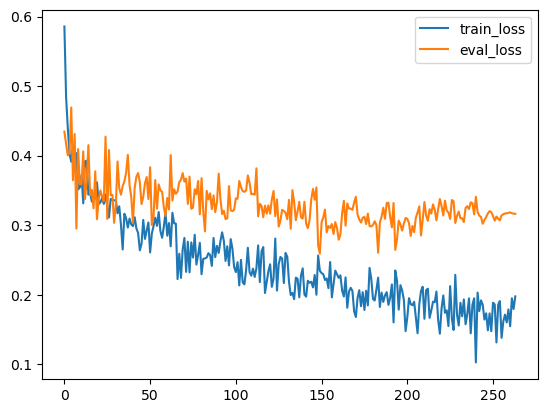

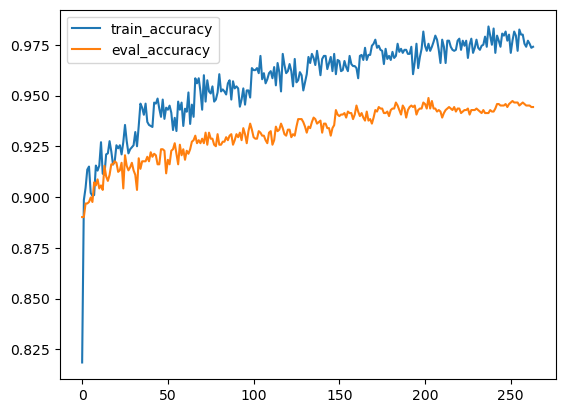

In [9]:
# Plot the results
import matplotlib.pyplot as plt

train_loss = []
train_accuracy = []
eval_loss = []
eval_accuracy = []

for log in trainer.state.log_history:
    if 'loss' in log:
        train_loss.append(log["loss"])
    if 'train_accuracy' in log:
        train_accuracy.append(log["train_accuracy"])
    elif 'eval_loss' in log:
        eval_loss.append(log["eval_loss"])
        eval_accuracy.append(log["eval_accuracy"])

plt.plot(train_loss, label="train_loss")
plt.plot(eval_loss, label="eval_loss")
plt.legend()
plt.show()

plt.plot(train_accuracy, label="train_accuracy")
plt.plot(eval_accuracy, label="eval_accuracy")
plt.legend()
plt.show()

In [10]:
# Load the best model and test 

# Find the best model checkpoint
max_accuracy = 0
for log in trainer.state.log_history:
    if 'eval_accuracy' in log:
        if log['eval_accuracy'] > max_accuracy:
            max_accuracy = log['eval_accuracy']
            best_checkpoint = log['step']

print(best_checkpoint)

best_model = RobertaForSequenceClassification.from_pretrained(f"./lora_results/checkpoint-{best_checkpoint}")

# Test the best model
trainer = Trainer(
    model=best_model, 
    args=training_args,
    train_dataset=tokenized_dataset["train"], 
    eval_dataset=tokenized_dataset["test"],
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

trainer.evaluate()


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


101500


f:\Programs\anaconda3\envs\ssm_hw5\lib\site-packages\accelerate\accelerator.py:446: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False)
  warnings.warn(
100%|██████████| 218/218 [00:04<00:00, 45.97it/s]


{'eval_loss': 0.3850848078727722,
 'eval_accuracy': 0.9380733944954128,
 'eval_runtime': 4.7703,
 'eval_samples_per_second': 182.799,
 'eval_steps_per_second': 45.7}